NESTML active dendrite third-factor STDP synapse
==========================================

In this tutorial, a neuron and synapse model are defined in NESTML that are subsequently used in a network to perform learning, prediction and replay of sequences of items, such as letters, images or sounds [1].

<a name="introduction"></a>

Introduction
------------


In [1]:
%matplotlib inline

from typing import List, Optional

import matplotlib as mpl

mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = [8., 3.]
# plt.rcParams['font.size'] = 8
# plt.rcParams['legend.fontsize']= 6
# plt.rcParams['figure.figsize'] = fig_size
# plt.rcParams['savefig.dpi'] = 300
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['lines.linewidth'] = 1
# plt.rcParams['text.usetex'] = False


import matplotlib.pyplot as plt
import nest
import nest.raster_plot
import numpy as np
import os
import random
import re

import parameters as para

import shtm
#import shtm.model
import shtm.helper
from shtm import helper  # XXX
import copy
import time

import random
import os
import nest
import copy
import numpy as np
from collections import defaultdict


from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils
from pynestml.codegeneration.nest_tools import NESTTools

n_threads = 1   # number of threads to use for simulations. This depends on your computer hardware.

/home/charl/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: stdsp_synapse@1ac64c90c
 Built: Mar 13 2024 04:34:39

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [21]:
class Model:
    """Instantiation of the Spiking-TemporalMemory model and its PyNEST implementation.

    the model provides the following member functions: 

    __init__(parameters)
    create()
    connect()
    simulate(t_sim)

    In addition, each model may implement other model-specific member functions.
    """

    def __init__(self, params, sequences, vocabulary):
        """Initialize model and simulation instance, including

        1) parameter setting,
        2) generate sequence data,
        3) configuration of the NEST kernel,
        4) setting random-number generator seed, and

        Parameters
        ----------
        params:    dict
                   Parameter dictionary
        """

        print('\nInitialising model and simulation...')

        # set parameters derived from base parameters
        self.params = helper.derived_parameters(params)
        print("Model parameters: " + str(self.params))

        # data directory
        self.data_path = self.params['label']

        try:
            os.mkdir(self.data_path)
        except:
            pass

        print("Data will be written to: {}\n".format(self.data_path))

        # set network size
        self.num_subpopulations = params['M']
        self.num_exc_neurons = params['n_E'] * self.num_subpopulations

        # initialize RNG        
        np.random.seed(self.params['seed'])
        random.seed(self.params['seed'])

        # input stream: sequence data
        self.sequences = sequences
        self.vocabulary = vocabulary
        self.length_sequence = len(self.sequences[0])
        self.num_sequences = len(self.sequences)

        # initialize the NEST kernel
        self.__setup_nest()

        # get time constant for dendriticAP rate
        self.params['soma_params']['tau_h'] = self.__get_time_constant_dendritic_rate(
            calibration=self.params['calibration'])

    def __setup_nest(self):
        """Initializes the NEST kernel.
        """

        nest.ResetKernel()
        nest.SetKernelStatus({
            'resolution': self.params['dt'],
            'print_time': self.params['print_simulation_progress'],
            'local_num_threads': n_threads,
            'rng_seed': self.params['seed'],
            'dict_miss_is_error': True,
            'overwrite_files': self.params['overwrite_files'],
            'data_path': str(self.data_path),
            'data_prefix': ''
        })

    def create(self):
        """Create and configure all network nodes (neurons + recording and stimulus devices)
        """

        print('\nCreating and configuring nodes...')

        # create excitatory population
        self.__create_neuronal_populations()

        # compute timing of the external inputs and recording devices
        # TODO: this function should probably not be part of the model
        excitation_times, excitation_times_neuron, idend_recording_times = self.__compute_timing_external_inputs(
                self.params['DeltaT'], self.params['DeltaT_seq'], self.params['DeltaT_cue'], 
                self.params['excitation_start'], self.params['time_dend_to_somatic'])

        # create spike generators
        self.__create_spike_generators(excitation_times_neuron)

        # create recording devices
        self.__create_recording_devices(excitation_times, idend_recording_times)

        # create weight recorder
        if self.params['active_weight_recorder']:
            self.__create_weight_recorder()

    def connect(self):
        """Connects network and devices
        """

        print('\nConnecting network and devices...')
        # TODO: take into account L (number of subpopulations per character) when connecting the network

        # connect excitatory population (EE)
        if self.params['load_connections']:
            self.__load_connections(label='ee_connections')
        else:
            self.__connect_excitatory_neurons()

            # connect inhibitory population (II, EI, IE)
        self.__connect_inhibitory_neurons()

        # connect external input
        self.__connect_external_inputs_to_subpopulations()

        # connect neurons to the spike recorder
        nest.Connect(self.exc_neurons, self.spike_recorder_soma)
        nest.Connect(self.exc_neurons, self.spike_recorder_soma_)
        nest.Connect(self.inh_neurons, self.spike_recorder_inh)
        nest.Connect(self.inh_neurons, self.spike_recorder_inh_)

        # connect multimeter for recording dendritic current
        if self.params['evaluate_performance']:
            nest.Connect(self.multimeter_idend_eval, self.exc_neurons)
            nest.Connect(self.multimeter_idend_eval_, self.exc_neurons)
            nest.Connect(self.multimeter_vm_eval_, self.exc_neurons)

        # connect multimeter for recording dendritic current from all subpopulations of the last trial
        if self.params['record_idend_last_episode']:
            nest.Connect(self.multimeter_idend_last_episode, self.exc_neurons)

        # set min synaptic strength
        self.__set_min_synaptic_strength()

    def simulate(self):
        """Run simulation.
        """

        # the simulation time is set during the creation of the network  
        if nest.Rank() == 0:
            print('\nSimulating {} ms.'.format(self.sim_time))

        nest.Simulate(self.sim_time)

    def __create_neuronal_populations(self):
        """'Create neuronal populations
        """

        # create excitatory population
        self.exc_neurons = nest.Create(self.params['soma_model'],
                                       self.num_exc_neurons,
                                       params=self.params['soma_params'])

        # create inhibitory population
        self.inh_neurons = nest.Create(self.params['inhibit_model'],
                                       self.params['n_I'] * self.num_subpopulations,
                                       params=self.params['inhibit_params'])

    def __create_spike_generators(self, excitation_times_neuron):
        """Create spike generators
        """

        excitation_times_soma, excitation_times_dend = excitation_times_neuron 

        self.input_excitation_soma = {}
        self.input_excitation_dend = {}
        for char in self.vocabulary:
            self.input_excitation_soma[char] = nest.Create('spike_generator')
            self.input_excitation_dend[char] = nest.Create('spike_generator')

        # set spike generator status with the above computed excitation times
        for char in self.vocabulary:
            nest.SetStatus(self.input_excitation_soma[char], {'spike_times': excitation_times_soma[char]})

        # this makes the first population in the sequence sparse
        if self.params['sparse_first_char']:
            first_chars = [char for seq in self.sequences for char in [seq[0]]]
            for char in first_chars:
                nest.SetStatus(self.input_excitation_dend[char], {'spike_times': excitation_times_dend[char]})

    def __create_recording_devices(self, excitation_times, idend_recording_times):
        """Create recording devices
        """
    
        # create a spike recorder for exc neurons
        self.spike_recorder_soma = nest.Create('spike_recorder', params={'record_to': 'ascii','label': 'somatic_spikes'})
        self.spike_recorder_soma_ = nest.Create('spike_recorder', params={'label': 'somatic_spikes'})

        # create a spike recorder for inh neurons
        self.spike_recorder_inh = nest.Create('spike_recorder', params={'record_to': 'ascii','label': 'inh_spikes'})
        self.spike_recorder_inh_ = nest.Create('spike_recorder', params={'label': 'inh_spikes'})

        # create multimeter to record dendritic currents of exc_neurons at the time of the last element in the sequence
        if self.params['evaluate_performance']:
            self.multimeter_idend_eval = nest.Create('multimeter', self.num_sequences,
                                                     params={'record_from': ['I_dend'],
                                                             'record_to': 'ascii',
                                                             'label': 'idend_eval'})
            
            self.multimeter_idend_eval_ = nest.Create('multimeter',
                                                     params={'record_from': ['I_dend'],
                                                             'label': 'idend_eval'})
            self.multimeter_vm_eval_ = nest.Create('multimeter',
                                                     params={'record_from': ['V_m'],
                                                             'label': 'vm_eval'})


            for i in range(self.num_sequences):
                idend_eval_spec_dict = {'offset': idend_recording_times[i][0] + self.params['idend_record_time'],
                                        'interval': idend_recording_times[i][1] - idend_recording_times[i][0]}
                nest.SetStatus(self.multimeter_idend_eval[i], idend_eval_spec_dict)

            #nest.SetStatus(self.multimeter_idend_eval_, {"interval": nest.GetKernelStatus()["resolution"]})
            #nest.SetStatus(self.multimeter_vm_eval_, {"interval": nest.GetKernelStatus()["resolution"]})

        # create multimeter for recording dendritic current from all subpopulations of the last episode
        if self.params['record_idend_last_episode']:
            self.multimeter_idend_last_episode = nest.Create('multimeter', params={'record_from': ['I_dend'],
                                                                                   'record_to': 'ascii',
                                                                                   'label': 'idend_last_episode'})

            if self.params['evaluate_replay']:
                idend_dict = {'interval': self.params['idend_recording_interval'],
                              'start': self.params['excitation_start'],
                              'stop': self.params['excitation_start'] \
                                      + len(self.sequences) * self.params['DeltaT_cue']}

                nest.SetStatus(self.multimeter_idend_last_episode, idend_dict)
            else:
                number_elements_per_batch = sum([len(seq) for seq in self.sequences])
                idend_dict = {'interval': self.params['idend_recording_interval'],
                              'start': excitation_times[-number_elements_per_batch],
                              'stop': excitation_times[-1] + self.params['pad_time']}

                nest.SetStatus(self.multimeter_idend_last_episode, idend_dict)

    def __create_weight_recorder(self):
        """Create weight recorder
        """

        self.wr = nest.Create('weight_recorder', {'record_to': 'ascii', 'label': 'weight_recorder'})
        #self.params['syn_dict_ee']['weight_recorder'] = self.wr
        nest.CopyModel(params['syn_dict_ee']['synapse_model'], 'stdsp_synapse_rec', {'weight_recorder': self.wr})
        self.params['syn_dict_ee']['synapse_model'] = 'stdsp_synapse_rec'

    def __compute_timing_external_inputs(self, DeltaT, DeltaT_seq, DeltaT_cue, excitation_start, time_dend_to_somatic):
        """Specifies the excitation times of the external input for each sequence element,
        subsequent sequence elements are presented  with  inter-stimulus interval DeltaT,  
        subsequent sequences are separated in time by an inter-sequence time interval DeltaT_seq,
        during the replay, the presented cues are seperated by an intercue time interval Delta_cue,
        In addition this function saves the times at which a dendritic current should be recorded,
        we don't want to record the dendritic current every time step as this consumes a lot of memory,
        so we instead record the dendritic current every 'episodes_to_testing' episodes,
        recording the dendritic current is essential for computing the prediction performance,
        the dendritic current is saved only at the time of last element in the sequence,
        this is because when assessing the prediction performance, we compute the prediction error 
        only with respect to the last element in the sequence
        
        Parameters
        ---------
        DeltaT               : float
        DeltaT_seq           : float
        DeltaT_cue           : float 
        excitation_start     : float
        time_dend_to_somatic : float

        Returns:
        --------
        excitation_times: list(float)
        excitation_times_soma: dict
        excitation_times_dend: dict
        idend_recording_times: dict
        """

        excitation_times_soma = defaultdict(list)
        excitation_times_dend = defaultdict(list)
        idend_recording_times = defaultdict(list)

        excitation_times = []
        sim_time = excitation_start
        for le in range(self.params['learning_episodes'] + 1):
            print("Learning episode: " + str(le) + " of " + str(self.params['learning_episodes'] + 1))

            for seq_num, sequence in enumerate(self.sequences):
                len_seq = len(sequence)
                for i, char in enumerate(sequence):

                    if i != 0:
                        sim_time += DeltaT

                    # store time of excitation for each symbol
                    excitation_times_soma[char] += [sim_time]
                    if i == 0:
                        excitation_times_dend[char] += [sim_time - time_dend_to_somatic]

                    # store dendritic spike times recording
                    if (i == len_seq - 2) and (le % self.params['episodes_to_testing'] == 0):
                        idend_recording_times[seq_num] += [sim_time]

                    excitation_times.append(sim_time)

                    if self.params['evaluate_replay']:
                        break

                # set timing between sequences
                if self.params['evaluate_replay']:
                    sim_time += DeltaT_cue
                else:
                    sim_time += DeltaT_seq

        # save data
        if self.params['evaluate_performance'] or self.params['evaluate_replay']:
            try:
              print("mkdir: " + str(self.data_path))
              os.mkdir(self.data_path)
            except:
              pass
            np.save('%s/%s' % (self.data_path, 'idend_recording_times'), idend_recording_times)
            print("Saving idend_recording_times to " + str(os.path.join(self.data_path, 'idend_recording_times')))
            np.save('%s/%s' % (self.data_path, 'excitation_times_soma'),
                    excitation_times_soma)
            np.save('%s/%s' % (self.data_path, 'excitation_times'), excitation_times)

        self.sim_time = sim_time
        return excitation_times, [excitation_times_soma, excitation_times_dend], idend_recording_times

    def __get_subpopulation_neurons(self, index_subpopulation):
        """Get neuron's indices (NEST NodeCollection) belonging to a subpopulation
        
        Parameters
        ---------
        index_subpopulation: int

        Returns
        -------
        NEST NodeCollection
        """

        neurons_indices = [int(index_subpopulation) * self.params['n_E'] + i for i in
                           range(self.params['n_E'])]

        return self.exc_neurons[neurons_indices]

    def __connect_excitatory_neurons(self):
        """Connect excitatory neurons
        """
        print("Conn exc neurons")
        print(self.params['conn_dict_ee'])
        print(self.params['syn_dict_ee'])
        nest.Connect(self.exc_neurons, self.exc_neurons, conn_spec=self.params['conn_dict_ee'],
                     syn_spec=self.params['syn_dict_ee'])
#        syn = nest.GetConnections(source=self.exc_neurons, target=self.exc_neurons, synapse_model=self.params["syn_dict_ee"]["synapse_model_name"])   # XXX
#        assert all(np.array(syn.weight) > 0)
#        import pdb;pdb.set_trace()

    def __connect_inhibitory_neurons(self):
        """Connect inhibitory neurons
        """

        for k, subpopulation_index in enumerate(range(self.num_subpopulations)):
            # connect inhibitory population 
            subpopulation_neurons = self.__get_subpopulation_neurons(subpopulation_index)

            # connect neurons within the same mini-subpopulation to the inhibitory population
            nest.Connect(subpopulation_neurons, self.inh_neurons[k], syn_spec=self.params['syn_dict_ie'])

            # connect the inhibitory neurons to the neurons within the same mini-subpopulation
            nest.Connect(self.inh_neurons[k], subpopulation_neurons, syn_spec=self.params['syn_dict_ei'])

    def __connect_external_inputs_to_subpopulations(self):
        """Connect external inputs to subpopulations
        """

        # get input encoding
        self.characters_to_subpopulations = self.__stimulus_preference(fname='characters_to_subpopulations')

        # save characters_to_subpopulations for evaluation
        if self.params['evaluate_performance'] or self.params['evaluate_replay']:
            fname = 'characters_to_subpopulations'
            np.save('%s/%s' % (self.data_path, fname), self.characters_to_subpopulations)

        for char in self.vocabulary:
            subpopulations_indices = self.characters_to_subpopulations[char]

            # receptor type 1 correspond to the feedforward synapse of the 'iaf_psc_exp_multisynapse' model
            for subpopulation_index in subpopulations_indices:
                subpopulation_neurons = self.__get_subpopulation_neurons(subpopulation_index)
                nest.Connect(self.input_excitation_soma[char], subpopulation_neurons,
                             self.params['conn_dict_ex'], syn_spec=self.params['syn_dict_ex'])
                nest.Connect(self.input_excitation_dend[char], subpopulation_neurons,
                             self.params['conn_dict_edx'], syn_spec=self.params['syn_dict_edx'])

    def __stimulus_preference(self, fname='characters_to_subpopulations'):
        """Assign a subset of subpopulations to a each element in the vocabulary.

        Parameters
        ----------
        fname : str

        Returns
        -------
        characters_to_subpopulations: dict
        """

        if len(self.vocabulary) * self.params['L'] > self.num_subpopulations:
            raise ValueError(
                "num_subpopulations needs to be large than length_user_characters*num_subpopulations_per_character")

        characters_to_subpopulations = defaultdict(list)  # a dictionary that assigns mini-subpopulation to characters

        subpopulation_indices = np.arange(self.num_subpopulations)
        # permuted_subpopulation_indices = np.random.permutation(subpopulation_indices)
        permuted_subpopulation_indices = subpopulation_indices
        index_characters_to_subpopulations = []

        if self.params['load_connections']:
            # load connectivity: from characters to mini-subpopulations
            
            characters_to_subpopulations = load_input_encoding(self.data_path, fname)
        else:
            for char in self.vocabulary:
                # randomly select a subset of mini-subpopulations for a character
                characters_to_subpopulations[char] = permuted_subpopulation_indices[:self.params['L']]
                # delete mini-subpopulations from the permuted_subpopulation_indices that are already selected
                permuted_subpopulation_indices = permuted_subpopulation_indices[self.params['L']:]

        return characters_to_subpopulations

    def __set_min_synaptic_strength(self):
        """Set synaptic Wmin
        """

        print('\nSet min synaptic strength ...')
        connections = nest.GetConnections(synapse_model=self.params['syn_dict_ee']['synapse_model'])
        print('\nSet min synaptic strength .2..')

        if "stdsp" in self.params['syn_dict_ee']['synapse_model']:
            print('\nSet min synaptic strength .3..')
            #import pdb;pdb.set_trace()
            if "synapse_nestml" in synapse_model_name:
                connections.set({'permanence_min': connections.permanence})
            else:
                connections.set({'Pmin': connections.permanence})
            
            print('\nSet min synaptic strength .3..')
        else:
            print('\nSet min synaptic strength .4..')
            connections.set({'Wmin': connections.weight})
            print('\nSet min synaptic strength .4..')

    def save_connections(self, fname='ee_connections'):
        """Save connection matrix

        Parameters
        ----------
        label: str
            name of the stored file
        """

        print('\nSave connections to ' + '%s/%s' % (self.data_path, fname) + '...')
        connections_all = nest.GetConnections(synapse_model=self.params['syn_dict_ee']['synapse_model'])

        connections = nest.GetStatus(connections_all, ['target', 'source', 'weight', 'permanence'])

        np.save('%s/%s' % (self.data_path, fname), connections)

    def __load_connections(self, label='ee_connections'):
        """Load connection matrix
        
        Parameters
        ----------
        label: str
            name of the stored file
        """

        assert self.params['syn_dict_ee']['synapse_model'] != 'stdsp_synapse_rec', "synapse model not tested yet"

        print('\nLoad connections ...')
        conns = np.load('%s/%s.npy' % (self.data_path, label))
        conns_tg = [int(conn[0]) for conn in conns]
        conns_src = [int(conn[1]) for conn in conns]
        conns_weights = [conn[2] for conn in conns]

        if "stdsp" in self.params['syn_dict_ee']['synapse_model']:
            conns_perms = [conn[3] for conn in conns]

        if self.params['evaluate_replay']:
            syn_dict = {'receptor_type': 2,
                        'delay': [self.params['syn_dict_ee']['delay']] * len(conns_weights),
                        'weight': conns_weights}
            nest.Connect(conns_src, conns_tg, 'one_to_one', syn_dict)
        else:
            syn_dict_ee = copy.deepcopy(self.params['syn_dict_ee'])

            del syn_dict_ee['synapse_model']
            del syn_dict_ee['weight']
            del syn_dict_ee['receptor_type']
            if "stdsp" in self.params['syn_dict_ee']['synapse_model']:
                del syn_dict_ee['permanence']

            nest.SetDefaults(self.params['syn_dict_ee']['synapse_model'], syn_dict_ee)

            if "stdsp" in self.params['syn_dict_ee']['synapse_model']:
                syn_dict = {'synapse_model': self.params['syn_dict_ee']['synapse_model'],
                            'receptor_type': 2,
                            'weight': conns_weights,
                            'permanence': conns_perms}
            else:
                syn_dict = {'synapse_model': self.params['syn_dict_ee']['synapse_model'],
                            'receptor_type': 2,
                            'weight': conns_weights}

            nest.Connect(conns_src, conns_tg, 'one_to_one', syn_dict)

    def __get_time_constant_dendritic_rate(self, DeltaT=40., DeltaT_seq=100., calibration=100, target_firing_rate=1):
        """Compute time constant of the dendritic AP rate,

        The time constant is set such that the rate captures how many dAPs a neuron generated
        all along the period of a batch
         
        Parameters
        ----------
        calibration : float
        target_firing_rate : float

        Returns
        -------
        float
           time constant of the dendritic AP rate
        """

        t_exc = ((self.length_sequence-1) * DeltaT + DeltaT_seq + calibration) \
                * self.num_sequences

        print("\nDuration of a sequence set %d ms" % t_exc)

        return target_firing_rate * t_exc


###########################################
def load_input_encoding(path, fname):
    """Load input encoding: association between sequence element and subpopulations

    Parameters
    ----------
    path: str
    fname: str

    Returns
    -------
    characters_to_subpopulations: dict
    """

    characters_to_subpopulations = helper.load_data(path, fname)

    return characters_to_subpopulations



## Generating code with NESTML

We will take a simple current-based integrate-and-fire model with alpha-shaped postsynaptic response kernels (``iaf_psc_alpha``) as the basis for our modifications. First, let's take a look at this base neuron without any modifications.

We will use a helper function to generate the C++ code for the models, build it as a NEST extension module, and load the module into the kernel. Because NEST does not support un- or reloading of modules at the time of writing, we implement a workaround that appends a unique number to the name of each generated model, for example, "iaf_psc_alpha_3cc945f". The resulting neuron model name is returned by the function, so we do not have to think about these internals.

In [3]:
%pdb
# codegen_opts = {"neuron_synapse_pairs": [{"neuron": "iaf_psc_exp_dend",
#                                           "synapse": "third_factor_stdp_synapse",
#                                           "post_ports": ["post_spikes",
#       http://localhost:8888/notebooks/doc/tutorials/sequences/sequences.ipynb#            
#["I_post_dend", "I_dend"]]}]}

# if not NESTTools.detect_nest_version().startswith("v2"):
#     codegen_opts["neuron_parent_class"] = "StructuralPlasticityNode"
#     codegen_opts["neuron_parent_class_include"] = "structural_plasticity_node.h"

# generate the "jit" model (co-generated neuron and synapse), that does not rely on ArchivingNode
# files = [os.path.join("models", "neurons", "iaf_psc_exp_dend_neuron.nestml"),
#          os.path.join("models", "synapses", "third_factor_stdp_synapse.nestml")]
# input_path = [os.path.realpath(os.path.join(os.path.dirname(__file__), os.path.join(
#     os.pardir, os.pardir, s))) for s in files]
# generate_nest_target(input_path=input_path,
#                      target_path="/tmp/nestml-jit",
#                      logging_level="INFO",
#                      module_name="nestml_jit_module",
#                      codegen_opts=codegen_opts)
#nest.Install("nestml_jit_module")

# generate and build code

try:
    module_name, neuron_model_name, synapse_model_name = \
        NESTCodeGeneratorUtils.generate_code_for("../../../doc/tutorials/sequences/iaf_psc_exp_nonlineardendrite_neuron.nestml",
                                                 "../../../models/synapses/stdsp_synapse.nestml",
                                                 logging_level="DEBUG",
                                                 post_ports=["post_spikes", ["dAP_trace", "dAP_trace"]],
                                                 codegen_opts={"neuron_parent_class_include": "archiving_node_ext.h",    "neuron_parent_class": "ArchivingNodeExt"})

except:
    module_name, neuron_model_name, synapse_model_name = \
        NESTCodeGeneratorUtils.generate_code_for("doc/tutorials/sequences/iaf_psc_exp_nonlineardendrite_neuron.nestml",
                                                 "models/synapses/stdsp_synapse.nestml",
                                                 logging_level="DEBUG",
                                                 post_ports=["post_spikes", ["dAP_trace", "dAP_trace"]],
                                                 codegen_opts={"neuron_parent_class_include": "archiving_node_ext.h",    "neuron_parent_class": "ArchivingNodeExt"})




"""
module_name = "nestml_54625aa90f64441d99f6349782e7215c_module"
neuron_model_name = "iaf_psc_exp_nonlineardendrite54625aa90f64441d99f6349782e7215c_neuron_nestml__with_stdsp54625aa90f64441d99f6349782e7215c_synapse_nestml"
synapse_model_name = "stdsp54625aa90f64441d99f6349782e7215c_synapse_nestml__with_iaf_psc_exp_nonlineardendrite54625aa90f64441d99f6349782e7215c_neuron_nestml"
"""



# JUST THE NEURON MODEL
"""
module_name, neuron_model_name = \
    NESTCodeGeneratorUtils.generate_code_for("doc/tutorials/sequences/iaf_psc_exp_nonlineardendrite_neuron.nestml",
                                             logging_level="DEBUG",
                                            codegen_opts = {
    "neuron_parent_class_include": "archiving_node_ext.h",
    "neuron_parent_class": "ArchivingNodeExt",
            }
)
"""


"""

# LASTLOG: using a manually modified neuron model (because it needs the get_dendritic_firing_rate() method)
# in combination with the NEST built-in stdsp_synapse

# run as LD_LIBRARY_PATH=/tmp/nestml_target_olo6bfq7:/home/charl/julich/nest-simulator-install/lib/nest:/home/charl/julich/nest-simulator-install/lib/python3.11/site-packages/nest:/home/charl/julich/nest-simulator-install/pynest PYTHONPATH=/home/charl/julich/nest-simulator-install/lib/python3.11/site-packages:`pwd`:/home/charl/julich/ode-toolbox-upstream/ode-toolbox/ ipython3 -i doc/tutorials/sequences/sequences.ipynb

neuron_model_name = "iaf_psc_exp_nonlineardendrite609ae82391c641f7ad702d2c8ed1ea9f_neuron_nestml"
module_name = "nestml_609ae82391c641f7ad702d2c8ed1ea9f_module"

synapse_model_name = "stdsp_synapse"

"""

# load dynamic library (NEST extension module) into NEST kernel
nest.Install(module_name)

Automatic pdb calling has been turned ON
[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /home/charl/julich/nestml-fork-clopath_synapse/nestml/doc/tutorials/sequences/iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron.nestml
[3,GLOBAL, INFO]: /home/charl/julich/nestml-fork-clopath_synapse/nestml/doc/tutorials/sequences/stdsp610c8a79f7f14886a9dbe3946c4b2740_synapse.nestml
[4,GLOBAL, INFO]: Target platform code will be generated in directory: '/home/charl/julich/nestml-fork-clopath_synapse/nestml/doc/tutorials/sequences/target'
[5,GLOBAL, INFO]: Target platform code will be installed in directory: '/tmp/nestml_target__b3u16m3'

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: stdsp_synapse@1ac64c90c
 Built: Mar 13 2024 04:34:39

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to fi

INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "I_dend' = I_dend__DOLLAR - I_dend / tau_syn2",
            "initial_values": {
                "I_dend": "0"
            }
        },
        {
            "expression": "I_dend__DOLLAR' = (-I_dend__DOLLAR) / tau_syn2",
            "initial_values": {
                "I_dend__DOLLAR": "0 / 1.0"
            }
        },
        {
            "expression": "V_m' = (-(V_m - E_L)) / tau_m + ((I_kernel1__X__I_1 * 1.0 - I_kernel3__X__I_3 * 1.0 + I_e) + I_dend) / C_m",
            "initial_values": {
                "V_m": "0"
            }
        },
        {
            "expression": "dAP_trace' = (-dAP_trace) / tau_h",
            "initial_values": {
                "dAP_trace": "0"
            }
        },
        {
            "expression": "I_kernel1__X__I_1 = exp(-1 / tau_syn1 * t)",
            "initial_values": {}
        },
        {
            "expression": "I_kernel3__X__I_3 = exp(-1 / tau_syn3 *

[58,stdsp610c8a79f7f14886a9dbe3946c4b2740_synapse_nestml__with_iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml, WARNING, [21:8;21:28]]: Variable 'd' has the same name as a physical unit!
[59,GLOBAL, INFO]: Successfully constructed neuron-synapse pair iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml__with_stdsp610c8a79f7f14886a9dbe3946c4b2740_synapse_nestml, stdsp610c8a79f7f14886a9dbe3946c4b2740_synapse_nestml__with_iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml
[60,GLOBAL, INFO]: Analysing/transforming model 'iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml'
[61,iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml, INFO, [1:0;115:0]]: Starts processing of the model 'iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml'


INFO:All known variables: [I_dend, I_dend__DOLLAR, V_m, dAP_trace, I_kernel1__X__I_1, I_kernel3__X__I_3], all parameters used in ODEs: {I_e, tau_syn1, tau_syn2, tau_h, E_L, tau_syn3, tau_m, C_m}
INFO:
Processing differential-equation form shape I_dend with defining expression = "I_dend__DOLLAR - I_dend / tau_syn2"
DEBUG:Splitting expression -I_dend/tau_syn2 + I_dend__DOLLAR (symbols [I_dend, I_dend__DOLLAR, V_m, dAP_trace, I_kernel1__X__I_1, I_kernel3__X__I_3, I_dend])
DEBUG:	linear factors: Matrix([[-1/tau_syn2], [1], [0], [0], [0], [0], [0]])
DEBUG:	inhomogeneous term: 0.0
DEBUG:	nonlinear term: 0.0
DEBUG:Created Shape with symbol I_dend, derivative_factors = [-1/tau_syn2], inhom_term = 0.0, nonlin_term = I_dend__DOLLAR
INFO:	Returning shape: Shape "I_dend" of order 1
INFO:
Processing differential-equation form shape I_dend__DOLLAR with defining expression = "(-I_dend__DOLLAR) / tau_syn2"
DEBUG:Splitting expression -I_dend__DOLLAR/tau_syn2 (symbols [I_dend, I_dend__DOLLAR, V_m, dAP_t

[62,iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml, DEBUG, [1:0;115:0]]: Start building symbol table!
[63,iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml, INFO, [91:30;91:88]]: Implicit casting from (compatible) type '1 / ms' to 'real'.


INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "I_dend' = I_dend__DOLLAR - I_dend / tau_syn2",
            "initial_values": {
                "I_dend": "0"
            }
        },
        {
            "expression": "I_dend__DOLLAR' = (-I_dend__DOLLAR) / tau_syn2",
            "initial_values": {
                "I_dend__DOLLAR": "0 / 1.0"
            }
        },
        {
            "expression": "V_m' = (-(V_m - E_L)) / tau_m + ((I_kernel1__X__I_1 * 1.0 - I_kernel3__X__I_3 * 1.0 + I_e) + I_dend) / C_m",
            "initial_values": {
                "V_m": "0"
            }
        },
        {
            "expression": "dAP_trace' = (-dAP_trace) / tau_h",
            "initial_values": {
                "dAP_trace": "0"
            }
        },
        {
            "expression": "I_kernel3__X__I_3 = exp(-1 / tau_syn3 * t)",
            "initial_values": {}
        },
        {
            "expression": "I_kernel1__X__I_1 = exp(-1 / tau_syn1 *

[64,GLOBAL, INFO]: Analysing/transforming model 'iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml__with_stdsp610c8a79f7f14886a9dbe3946c4b2740_synapse_nestml'
[65,iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml__with_stdsp610c8a79f7f14886a9dbe3946c4b2740_synapse_nestml, INFO, [1:0;115:0]]: Starts processing of the model 'iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml__with_stdsp610c8a79f7f14886a9dbe3946c4b2740_synapse_nestml'


DEBUG:System of equations:
DEBUG:x = Matrix([[I_dend], [I_dend__DOLLAR], [V_m], [dAP_trace], [I_kernel3__X__I_3], [I_kernel1__X__I_1]])
DEBUG:A = Matrix([
[-1/tau_syn2,           1,        0,        0,           0,           0],
[          0, -1/tau_syn2,        0,        0,           0,           0],
[      1/C_m,           0, -1/tau_m,        0,    -1.0/C_m,     1.0/C_m],
[          0,           0,        0, -1/tau_h,           0,           0],
[          0,           0,        0,        0, -1/tau_syn3,           0],
[          0,           0,        0,        0,           0, -1/tau_syn1]])
DEBUG:b = Matrix([[0.0], [0.0], [E_L/tau_m + I_e/C_m], [0.0], [0.0], [0.0]])
DEBUG:c = Matrix([[0], [0], [0], [0], [0], [0]])
INFO:update_expr[I_dend] = I_dend*__P__I_dend__I_dend + I_dend__DOLLAR*__P__I_dend__I_dend__DOLLAR
INFO:update_expr[I_dend__DOLLAR] = I_dend__DOLLAR*__P__I_dend__DOLLAR__I_dend__DOLLAR
INFO:update_expr[V_m] = -E_L*__P__V_m__V_m + E_L + I_dend*__P__V_m__I_dend + I_dend__DOLL

[66,iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml__with_stdsp610c8a79f7f14886a9dbe3946c4b2740_synapse_nestml, DEBUG, [1:0;115:0]]: Start building symbol table!


INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "pre_trace' = (-pre_trace) / tau_pre_trace",
            "initial_values": {
                "pre_trace": "0.0"
            }
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "Wmax": "100.0",
        "Wmin": "0.0",
        "d": "1",
        "dt_max": "100",
        "dt_min": "4",
        "lambda_h": "1.0",
        "lambda_minus": "1.0",
        "lambda_plus": "0.01",
        "permanence_max": "100.0",
        "permanence_min": "0.0",
        "permanence_threshold": "10.0",
        "tau_pre_trace": "80",
        "zt": "1"
    }
}
INFO:Processing global options...
INFO:Processing input shapes...
INFO:
Processing differential-equation form shape pre_trace with defining expression = "(-pre_trace) / tau_pre_trace"
DEBUG:Splitting expression -pre_trace/tau_pre_trace (symbols [pre_trace])
DEBUG:	linear factors: Matrix([[-1/tau_pre_trace]])
DEBUG:	inhom

[67,iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml__with_stdsp610c8a79f7f14886a9dbe3946c4b2740_synapse_nestml, INFO, [91:30;91:88]]: Implicit casting from (compatible) type '1 / ms' to 'real'.
[68,GLOBAL, INFO]: Analysing/transforming synapse stdsp610c8a79f7f14886a9dbe3946c4b2740_synapse_nestml__with_iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml.
[69,stdsp610c8a79f7f14886a9dbe3946c4b2740_synapse_nestml__with_iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml, INFO, [12:0;83:0]]: Starts processing of the model 'stdsp610c8a79f7f14886a9dbe3946c4b2740_synapse_nestml__with_iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml'
[70,stdsp610c8a79f7f14886a9dbe3946c4b2740_synapse_nestml__with_iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml, DEBUG, [12:0;83:0]]: Start building symbol table!
[71,stdsp610c8a79f7f14886a9dbe3946c4b2740_synapse_nestml__with_iaf_psc_exp

Now, the NESTML model is ready to be used in a simulation.

## Helper functions

In [4]:
def psp_max_2_psc_max(psp_max, tau_m, tau_s, R_m):
    """Compute the PSC amplitude (pA) injected to get a certain PSP maximum (mV) for LIF with exponential PSCs

    Parameters
    ----------
    psp_max: float
             Maximum postsynaptic pontential
    tau_m:   float
             Membrane time constant (ms).
    tau_s:   float
             Synaptic time constant (ms).
    R_m:     float
             Membrane resistance (Gohm).

    Returns
    -------
    float
        PSC amplitude (pA).
    """

    return psp_max / (
            R_m * tau_s / (tau_s - tau_m) * (
            (tau_m / tau_s) ** (-tau_m / (tau_m - tau_s)) -
            (tau_m / tau_s) ** (-tau_s / (tau_m - tau_s))
    )
    )


## Experiment 1: dAP generation in the neuron model


In [5]:
def create_active_dendrite_parameters():
    p = para.ParameterSpace({})
    
    DELAY = 0.1
    
    p['dt'] = 0.1                                  # simulation time resolution (ms)
    p['print_simulation_progress'] = False         # print the time progress.
    
    
    # data path dict
    p['data_path'] = {}
    p['data_path']['data_root_path'] = 'data'
    p['data_path']['project_name'] = 'sequence_learning_performance'
    p['data_path']['parameterspace_label'] = 'effect_dAP_firing_times'
    
    # neuron parameters of the excitatory neurons
    p['soma_model'] = neuron_model_name
    p['soma_params'] = {}
    p['soma_params']['C_m'] = 250.        # membrane capacitance (pF)
    p['soma_params']['E_L'] = 0.          # resting membrane potential (mV)
    # p['soma_params']['I_e'] = 0.        # external DC currents (pA)
    p['soma_params']['V_m'] = 0.          # initial potential (mV)
    p['soma_params']['V_reset'] = 0.      # reset potential (mV)
    p['soma_params']['V_th'] = 20.        # spike threshold (mV)
    p['soma_params']['t_ref'] = 10.       # refractory period
    p['soma_params']['tau_m'] = 10.       # membrane time constant (ms)
    p['soma_params']['tau_syn1'] = 2.     # synaptic time constant: external input (receptor 1)
    p['soma_params']['tau_syn2'] = 5.     # synaptic time constant: dendrtic input (receptor 2)
    p['soma_params']['tau_syn3'] = 1.     # synaptic time constant: inhibitory input (receptor 3)
    # dendritic action potential
    p['soma_params']['I_p'] = 200. # current clamp value for I_dAP during a dendritic action potenti
    p['soma_params']['tau_dAP'] = 60.       # time window over which the dendritic current clamp is active
    p['soma_params']['theta_dAP'] = 59.        # current threshold for a dendritic action potential
    
    p['soma_params']['I_dend_incr'] = 2.71 / (p['soma_params']['tau_syn2'])
    
    
    p['fixed_somatic_delay'] = 2          # this is an approximate time of how long it takes the soma to fire
                                          # upon receiving an external stimulus 
    
    # neuron parameters for the inhibitory neuron
    p['inhibit_model'] = 'iaf_psc_exp'
    p['inhibit_params'] = {}
    p['inhibit_params']['C_m'] = 250.         # membrane capacitance (pF)
    p['inhibit_params']['E_L'] = 0.           # resting membrane potential (mV)
    p['inhibit_params']['I_e'] = 0.           # external DC currents (pA)
    p['inhibit_params']['V_m'] = 0.           # initial potential (mV)
    p['inhibit_params']['V_reset'] = 0.       # reset potential (mV)
    p['inhibit_params']['V_th'] = 15.         # spike threshold (mV)
    p['inhibit_params']['t_ref'] = 2.0        # refractory period
    p['inhibit_params']['tau_m'] = 5.         # membrane time constant (ms)
    p['inhibit_params']['tau_syn_ex'] = .5    # synaptic time constant of an excitatory input (ms) 
    p['inhibit_params']['tau_syn_in'] = 1.65  # synaptic time constant of an inhibitory input (ms)
    
    # synaptic parameters
    p['J_EX_psp'] = 1.1 * p['soma_params']['V_th']     # somatic PSP as a response to an external input
    p['J_IE_psp'] = 1.2 * p['inhibit_params']['V_th']  # inhibitory PSP as a response to an input from E neuron
    p['J_EI_psp'] = -2 * p['soma_params']['V_th']      # somatic PSP as a response to an inhibitory input
    p['convergence'] = 5
    p['pattern_size'] = 20
    
    # parameters for ee synapses (stdsp)
    p['syn_dict_ee'] = {}
    p['p_min'] = 0.
    p['p_max'] = 8.
    p['calibration'] = 40.
    p['syn_dict_ee']['weight'] = 0.01                    # synaptic weight
    p['syn_dict_ee']['synapse_model'] = synapse_model_name  # synapse model
    p['syn_dict_ee']['permanence_threshold'] = 10.                    # synapse maturity threshold
    p['syn_dict_ee']['tau_pre_trace'] = 20.                   # plasticity time constant (potentiation)
    p['syn_dict_ee']['delay'] = 2.                       # dendritic delay 
    p['syn_dict_ee']['receptor_type'] = 2                # receptor corresponding to the dendritic input
    p['syn_dict_ee']['lambda_plus'] = 0.05 #0.1                     # potentiation rate
    p['syn_dict_ee']['zt'] = 1.                          # target dAP trace [pA]
    p['syn_dict_ee']['lambda_h'] = 0.01                        # homeostasis rate
    p['syn_dict_ee']['Wmax'] = 1.1 * p['soma_params']['theta_dAP'] / p['convergence']   # Maximum allowed weight

    if "synapse_nestml" in synapse_model_name:
        p['syn_dict_ee']['permanence_max'] = 20.                       # Maximum allowed permanence
        p['syn_dict_ee']['permanence_min'] = 1.                        # Minimum allowed permanence
    else:
        p['syn_dict_ee']['Pmax'] = 20.                       # Maximum allowed permanence
        p['syn_dict_ee']['Pmin'] = 1.                        # Minimum allowed permanence
    p['syn_dict_ee']['lambda_minus'] = 0.004
    
    # parameters of EX synapses (external to soma of E neurons)
    p['conn_dict_ex'] = {}
    p['syn_dict_ex'] = {}
    p['syn_dict_ex']['receptor_type'] = 1                    # receptor corresponding to external input
    p['syn_dict_ex']['delay'] = DELAY                        # dendritic delay
    p['conn_dict_ex']['rule'] = 'all_to_all'                 # connection rule
    
    # parameters of EdX synapses (external to dendrite of E neurons) 
    p['conn_dict_edx'] = {}
    p['syn_dict_edx'] = {}
    p['syn_dict_edx']['receptor_type'] = 2                    # receptor corresponding to the dendritic input
    p['syn_dict_edx']['delay'] = DELAY                        # dendritic delay
    p['syn_dict_edx']['weight'] = 1.4 * p['soma_params']['theta_dAP']
    p['conn_dict_edx']['rule'] = 'fixed_outdegree'            # connection rule
    p['conn_dict_edx']['outdegree'] = p['pattern_size'] + 1   # outdegree
    
    # parameters for IE synapses 
    p['syn_dict_ie'] = {}
    p['conn_dict_ie'] = {}
    p['syn_dict_ie']['synapse_model'] = 'static_synapse'     # synapse model
    p['syn_dict_ie']['delay'] = DELAY                        # dendritic delay
    p['conn_dict_ie']['rule'] = 'fixed_indegree'             # connection rule
    p['conn_dict_ie']['indegree'] = 5                        # indegree 
    
    # parameters for EI synapses
    p['syn_dict_ei'] = {}
    p['conn_dict_ei'] = {}
    p['syn_dict_ei']['synapse_model'] = 'static_synapse'     # synapse model
    p['syn_dict_ei']['delay'] = DELAY                        # dendritic delay
    p['syn_dict_ei']['receptor_type'] = 3                    # receptor corresponding to the inhibitory input  
    p['conn_dict_ei']['rule'] = 'fixed_indegree'             # connection rule
    p['conn_dict_ei']['indegree'] = 20                       # indegree
    
    
    p['R_m_soma'] = p['soma_params']['tau_m'] / p['soma_params']['C_m']
    p['R_m_inhibit'] = p['inhibit_params']['tau_m'] / p['inhibit_params']['C_m']
    p['syn_dict_ex']['weight'] = psp_max_2_psc_max(p['J_EX_psp'], 
                                                               p['soma_params']['tau_m'], 
                                                               p['soma_params']['tau_syn1'], 
                                                               p['R_m_soma'])
    p['syn_dict_ie']['weight'] = psp_max_2_psc_max(p['J_IE_psp'], 
                                                               p['inhibit_params']['tau_m'], 
                                                               p['inhibit_params']['tau_syn_ex'], 
                                                               p['R_m_inhibit'])
    p['syn_dict_ei']['weight'] = psp_max_2_psc_max(p['J_EI_psp'], 
                                                               p['soma_params']['tau_m'], 
                                                               p['soma_params']['tau_syn3'], 
                                                               p['R_m_soma'])

    
    p['soma_excitation_time'] = 25.
    p['dendrite_excitation_time'] = 3.

    return p

p = create_active_dendrite_parameters()

In [6]:
def run_psc_test(params):
    print("Running psc test simulation!")
    # init kernel
    seed = 1
    nest.ResetKernel()
    nest.set_verbosity("M_ALL")
    nest.SetKernelStatus({
        'resolution': params['dt'],
        'print_time': params['print_simulation_progress'],
        'local_num_threads': n_threads,
        'rng_seed': seed
    })

    #############################
    # create and connect neurons
    # ---------------------------

    # create excitatory population
    exc_neuron = nest.Create(params['soma_model'], params=params['soma_params'])

    ######################
    # Input stream/stimuli
    #---------------------
    input_excitation = nest.Create('spike_generator', params={'spike_times':[10.]})
    dendrite_excitation_1 = nest.Create('spike_generator', params={'spike_times':[50., 140.], "spike_weights": [1., 100.]})
    dendrite_excitation_2 = nest.Create('spike_generator', params={'spike_times':[90.]})

    nest.Connect(input_excitation, exc_neuron, syn_spec={'receptor_type': 1, 
                                                         'weight': 10000., 
                                                         'delay': 1.})

    nest.Connect(dendrite_excitation_1, exc_neuron, syn_spec={'receptor_type': 2, 
                                                         'weight': 1., 
                                                         'delay': 1.})

    nest.Connect(dendrite_excitation_2, exc_neuron, syn_spec={'receptor_type': 3, 
                                                         'weight': 100., 
                                                         'delay': 1.})

    mm = nest.Create('multimeter', params={'record_from': ['V_m', 'active_dendrite_readout', 'I_dend'], 'interval': 0.1})
    nest.Connect(mm, exc_neuron)

    # record spikes
    sd = nest.Create('spike_recorder')
    nest.Connect(exc_neuron, sd)

    print('### simulating network')
    nest.Prepare()
    nest.Run(250.)

    times = nest.GetStatus(mm)[0]['events']["times"] 
    voltage_soma = nest.GetStatus(mm)[0]['events']['V_m']  
    active_dendrite_readout = nest.GetStatus(mm)[0]['events']['active_dendrite_readout']
    I_dend = nest.GetStatus(mm)[0]['events']['I_dend']

    fig, ax = plt.subplots(nrows=3, dpi=600, figsize=(8,6))
    ax[0].plot(times, voltage_soma, label="V_m")
    ax[1].plot(times, active_dendrite_readout, label="active dend")
    ax[2].plot(times, I_dend, label="I_dend")
    for _ax in ax:
        _ax.legend()

    fig.savefig("/tmp/psc_test.png")



#import sys;sys.exit(0)

In [7]:
def run_active_dendrite_simulation(params):
    print("Running active dendrite simulation!")
    data = {}
    for i, name in enumerate(['ff', 'dendrite', 'ff_dendrite']): 
        print("Running experiment type: " + name)
        # init kernel
        seed = 1
        nest.ResetKernel()
        nest.set_verbosity("M_ALL")
        nest.SetKernelStatus({
            'resolution': params['dt'],
            'print_time': params['print_simulation_progress'],
            'local_num_threads': n_threads,
            'rng_seed': seed
        })
    
        data[name] = {}
    
        #############################
        # create and connect neurons
        # ---------------------------
    
        # create excitatory population
        exc_neuron = nest.Create(params['soma_model'], params=params['soma_params'])
    
        # create inhibitory population
        inh_neuron = nest.Create(params['inhibit_model'], params=params['inhibit_params'])
    
        # connect inhibition
        nest.Connect(exc_neuron, inh_neuron, syn_spec=params['syn_dict_ie'])
        nest.Connect(inh_neuron, exc_neuron, syn_spec=params['syn_dict_ei'])
    
        ######################
        # Input stream/stimuli
        #---------------------
        input_excitation = nest.Create('spike_generator', params={'spike_times':[params['soma_excitation_time']]})
        dendrite_excitation_1 = nest.Create('spike_generator', params={'spike_times':[params['dendrite_excitation_time']]})
        #dendrite_excitation_2 = nest.Create('spike_generator', params={'spike_times':[7.]})
        inhibition_excitation = nest.Create('spike_generator', params={'spike_times':[10.]})
    
        # excitation soma feedforward
        if name == 'ff' or name == 'ff_dendrite':
            nest.Connect(input_excitation, exc_neuron, syn_spec={'receptor_type': 1, 
                                                                 'weight': params['syn_dict_ex']['weight'], 
                                                                 'delay': params['syn_dict_ex']['delay']})

        # excitation dendrite 
        if name == 'dendrite' or name == 'ff_dendrite':
            nest.Connect(dendrite_excitation_1, exc_neuron, syn_spec={'receptor_type': 2, 
                                                                      'weight': params['syn_dict_edx']['weight'], 
                                                                      'delay': params['syn_dict_edx']['delay']})
    
        # record voltage inhibitory neuron 
        vm_inh = nest.Create('voltmeter', params={'record_from': ['V_m'], 'interval': 0.1})
        nest.Connect(vm_inh, inh_neuron)
    
        # record voltage soma
        vm_exc = nest.Create('voltmeter', params={'record_from': ['V_m'], 'interval': 0.1})
        nest.Connect(vm_exc, exc_neuron)
    
        active_dendrite_exc_mm = nest.Create('multimeter', params={'record_from': ['active_dendrite_readout', 'I_dend'], 'interval': 0.1})
        nest.Connect(active_dendrite_exc_mm, exc_neuron)
    
        # record spikes
        sd = nest.Create('spike_recorder')
        nest.Connect(exc_neuron, sd)
    
        # record inh spikes
        sd_inh = nest.Create('spike_recorder')
        nest.Connect(inh_neuron, sd_inh)
    
        print('### simulating network')
        #nest.Simulate(100.)
        nest.Prepare()
        nest.Run(100.)
    
        voltage_soma = nest.GetStatus(vm_exc)[0]['events']  
        active_dendrite = nest.GetStatus(active_dendrite_exc_mm)[0]['events']
        voltage_inhibit = nest.GetStatus(vm_inh)[0]['events'] 
        spikes_soma = nest.GetStatus(sd)[0]['events'] 
        spikes_inh = nest.GetStatus(sd_inh)[0]['events'] 
    
        data[name]['exc'] = voltage_soma 
        data[name]['exc_active_dendrite'] = active_dendrite 
        data[name]['inh'] = voltage_inhibit
        data[name]['spikes_exc'] = spikes_soma
        data[name]['spikes_inh'] = spikes_inh

    return data

data = run_active_dendrite_simulation(p)

Running active dendrite simulation!
Running experiment type: ff

Mar 26 16:00:02 iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Mar 26 16:00:02 iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml__with_stdsp610c8a79f7f14886a9dbe3946c4b2740_synapse_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!
### simulating network
Running experiment type: dendrite

Mar 26 16:00:02 SimulationManager::set_status [Info]: 
    Temporal resolution changed.

Mar 26 16:00:02 NodeManager::prepare_nodes [Info]: 
    Preparing 10 nodes for simulation.

Mar 26 16:00:02 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10
    Simulation time (ms): 100
    Number of OpenMP threads: 1
    Not using MPI

Mar 26 16:00:02 SimulationManager::run [Info]: 
 

DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/charl/.local/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=bold:stretch=normal:size=10.0.
DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=bold:stretch=normal:size=10.0 to DejaVu Sans ('/home/charl/.local/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf') with score of 0.050000.
DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=bold:stretch=normal:size=8.0.
DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=bold:stretch=normal:size=8.0 to DejaVu Sans ('/home/charl/.local/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-

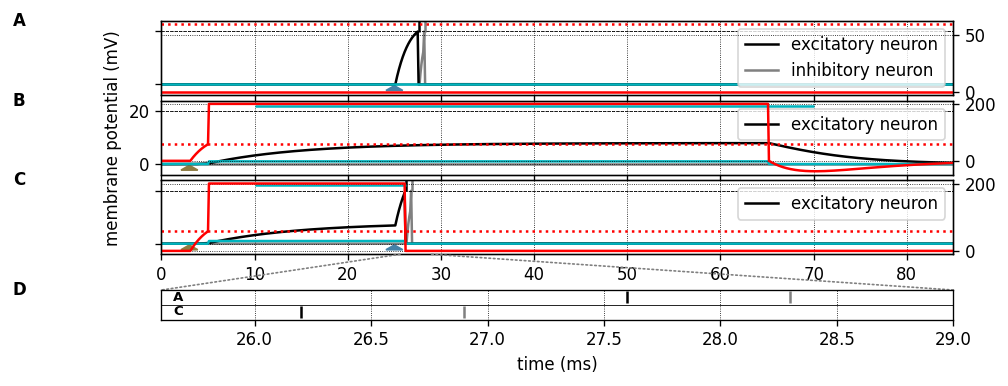

In [8]:
def plot_active_dendrite_simulation(params, data):
    
    
    def position_excitation_arrows(ax, soma_time, dendrite_time):
    
        arrow_width = 1.8
        arrow_height = 1.8
        y = -2.3
        
        # plot excitation arrows for panel A
        x = soma_time - arrow_width/2 
        pos = [x, y]
        X = np.array([pos, [pos[0]+arrow_width, pos[1]], [pos[0]+arrow_width/2, pos[1]+arrow_height]])
        t1 = plt.Polygon(X, color=color_somatic_input)
        ax[0].add_patch(t1)
    
        # plot excitation arrows for panel B
        x = dendrite_time - arrow_width/2 
        pos = [x, y]
        X = np.array([pos, [pos[0]+arrow_width, pos[1]], [pos[0]+arrow_width/2, pos[1]+arrow_height]])
        t1 = plt.Polygon(X, color=color_dAP_input)
        ax[1].add_patch(t1)
    
        # plot excitation arrows for panel C
        x = dendrite_time - arrow_width/2 
        pos = [x, y]
        X = np.array([pos, [pos[0]+arrow_width, pos[1]], [pos[0]+arrow_width/2, pos[1]+arrow_height]])
        t1 = plt.Polygon(X, color=color_dAP_input)
        ax[2].add_patch(t1)
    
        x = soma_time - arrow_width/2 
        pos = [x, y]
        X = np.array([pos, [pos[0]+arrow_width, pos[1]], [pos[0]+arrow_width/2, pos[1]+arrow_height]])
        t1 = plt.Polygon(X, color=color_somatic_input)
        ax[2].add_patch(t1)
    
    
    color_dAP_input = '#8e7c42ff'
    #color_somatic_input = '#0000ffff'
    color_somatic_input = '#4581a7ff'
    color_soma = '#000000ff'
    color_dAP = '#00B4BE' 
    color_inhibit = '#808080ff'  
    color_hrl = 'black'
    
    #color_somatic_spike = '#ff0000ff'
    color_somatic_spike = color_soma
    color_inh_spike = color_inhibit
    ms_spike = 7
    mew_spike = 1.5
    lw_vtheta = 0.5
    lw_dAP = 1.5
    lw_s = 1.5
    lw_i = 1.5
    
    # plot settings 
    fig_size = (6., 5)
    ymin = -4
    ymax = params['soma_params']['V_th'] + 4
    xmin = 0  
    xmax = 85
    label_pos = (-0.18, 1.)
    panel_labels = ['A', 'B', 'C']
    v_th=params['soma_params']['V_th'] 
    time_dAP = 10
    
    # set up the figure frame
    fig = plt.figure()
    gs = mpl.gridspec.GridSpec(5, 1, height_ratios=[15,15,15,5,6], bottom=0.1, right=0.95, top=0.93, wspace=0., hspace=0.1)
    left, bottom, width, height = [0.4, 0.1, 0.2, 0.2]
    axes = []
    
    
    
    for i, name in enumerate(['ff', 'dendrite', 'ff_dendrite']):
    
        #ax = fig.add_subplot(gs[i,0])
        ax = plt.subplot(gs[i,0])
        ax.text(label_pos[0], label_pos[1], panel_labels[i], transform=ax.transAxes, horizontalalignment='center', verticalalignment='center', size=10, weight='bold')
        ax.plot(data[name]['exc']['times'], data[name]['exc']['V_m'], lw=lw_s, color=color_soma, zorder=2, label='excitatory neuron')  
        
        
        ax.plot(data[name]['exc_active_dendrite']['times'], data[name]['exc_active_dendrite']['active_dendrite_readout'], lw=lw_s, color=color_dAP)  
        
        ax_ = ax.twinx()
        ax_.plot(data[name]['exc_active_dendrite']['times'], data[name]['exc_active_dendrite']['I_dend'], lw=lw_s, color="red", label="I_dend")  
        ax_.plot((0., np.amax(data[name]['exc_active_dendrite']['times'])), 2*[p['soma_params']['theta_dAP']], c="red", linestyle=':')
                 
        ax.plot(data[name]['spikes_exc']['times'], (v_th+2)*np.ones(len(data[name]['spikes_exc']['times'])), '|', c=color_somatic_spike, ms=ms_spike, mew=mew_spike)
        ax.plot(data[name]['spikes_inh']['times'], (v_th+2)*np.ones(len(data[name]['spikes_inh']['times'])), '|', c=color_inh_spike, ms=ms_spike, mew=mew_spike)
        ax.legend()
     
        # add dendritic action potential bar manually
        if name == 'dendrite': 
            ax.hlines(v_th+2, time_dAP, time_dAP+params['soma_params']['tau_dAP'], lw=lw_dAP, color=color_dAP)
    
        if name == 'ff_dendrite': 
            ax.hlines(v_th+2, time_dAP, data[name]['spikes_exc']['times'][0], lw=lw_dAP, color=color_dAP)
    
        # clamp voltage if doesn't reach the firing threshold
        if name == 'ff' or name == 'ff_dendrite': 
            max_volt = max(data[name]['inh']['V_m']) 
            max_volt_ind = np.where(data[name]['inh']['V_m']==max_volt)[0]
            data[name]['inh']['V_m'][max_volt_ind] = 20
    
        ax.plot(data[name]['inh']['times'], data[name]['inh']['V_m'], lw=lw_i, color=color_inhibit, zorder=1, label='inhibitory neuron') 
        ax.set_ylim([ymin, ymax])
        ax.set_xlim([xmin, xmax])
        ax.hlines(v_th, xmin, xmax, lw=lw_vtheta, color=color_hrl, linestyle='--')
    
        axes.append(ax)
    
    axes[1].set_ylabel('membrane potential (mV)')
    
    # set position of arrows
    position_excitation_arrows(axes, p['soma_excitation_time'], p['dendrite_excitation_time'])
    
    axes[0].legend(loc='center right')
    axes[0].set_yticklabels([])
    axes[0].set_xticklabels([])
    axes[1].set_xticklabels([])
    axes[2].set_yticklabels([])
    axes[2].set_xlabel('time (ms)')
    
    ########################################
    # plt spikes of A and B
    # --------------------------------------
    ax = fig.add_subplot(gs[i+1,0])
    plt.axis('off')
    
    ax = plt.subplot(gs[i+2,0])
    ax.text(label_pos[0], label_pos[1], 'D', transform=ax.transAxes, horizontalalignment='center', verticalalignment='center', size=10, weight='bold')
    
    xmin_d=25.6
    xmax_d=29
    
    ymin_d=0
    ymax_d=10
    
    name = 'ff'
    ax.plot(data[name]['spikes_exc']['times'], (3*ymax_d/4)*np.ones(len(data[name]['spikes_exc']['times'])), '|', c=color_somatic_spike, ms=ms_spike, mew=mew_spike)
    ax.plot(data[name]['spikes_inh']['times'], (3*ymax_d/4)*np.ones(len(data[name]['spikes_inh']['times'])), '|', c=color_inh_spike, ms=ms_spike, mew=mew_spike)
    
    name = 'ff_dendrite'
    ax.plot(data[name]['spikes_exc']['times'], (ymax_d/4)*np.ones(len(data[name]['spikes_exc']['times'])), '|', c=color_somatic_spike, ms=ms_spike, mew=mew_spike)
    ax.plot(data[name]['spikes_inh']['times'], (ymax_d/4)*np.ones(len(data[name]['spikes_inh']['times'])), '|', c=color_inh_spike, ms=ms_spike, mew=mew_spike)
    ax.hlines(ymax_d/2, xmin, xmax, lw=0.5, color=color_hrl, linestyles='solid')
    
    ax.set_yticklabels([])
    ax.tick_params(left=False)
    ax.set_ylim([ymin_d, ymax_d])
    ax.set_xlim([xmin_d, xmax_d])
    ax.set_xlabel('time (ms)')
    
    ax.text(xmin_d+0.05, (3*ymax_d/4)-1, 'A', size=8, weight='bold')
    ax.text(xmin_d+0.05, (ymax_d/4)-1, 'C', size=8, weight='bold')
    
    ############################################################
    # add lines between the subplots showing the zoomed in area
    # ----------------------------------------------------------
    xy_C = (xmin_d,ymin)
    xy_D = (xmin_d,ymax_d)
    con = mpl.patches.ConnectionPatch(xyA=xy_C, xyB=xy_D, coordsA='data', coordsB='data', axesA=axes[-1], axesB=ax, color='grey', linestyle='dotted')
    ax.add_artist(con)
    
    xy_C = (xmax_d,ymin)
    xy_D = (xmax_d,ymax_d)
    con = mpl.patches.ConnectionPatch(xyA=xy_C, xyB=xy_D, coordsA='data', coordsB='data', axesA=axes[-1], axesB=ax, color='grey', linestyle='dotted')
    ax.add_artist(con)
    
    plt.savefig("/tmp/sequences1.png")

plot_active_dendrite_simulation(p, data)


## Experiment 2: synaptic plasticity dependence on dAP

In [9]:
def create_stdsp_dependence_on_third_factor_parameters():
    DELAY = 0.1
    
    p = para.ParameterSpace({})
    
    p['dt'] = 0.1                                  # simulation time resolution (ms)
    p['print_simulation_progress'] = True         # print the time progress.
    
    # neuron parameters of the excitatory neurons
    p['soma_model'] = neuron_model_name
    p['soma_params'] = {}
    p['soma_params']['C_m'] = 250.        # membrane capacitance (pF)
    p['soma_params']['E_L'] = 0.          # resting membrane potential (mV)
    # p['soma_params']['I_e'] = 0.        # external DC currents (pA)
    p['soma_params']['V_m'] = 0.          # initial potential (mV)
    p['soma_params']['V_reset'] = 0.      # reset potential (mV)
    p['soma_params']['V_th'] = 20.        # spike threshold (mV)
    p['soma_params']['t_ref'] = 10.       # refractory period
    p['soma_params']['tau_m'] = 10.       # membrane time constant (ms)
    p['soma_params']['tau_syn1'] = 2.     # synaptic time constant: external input (receptor 1)
    p['soma_params']['tau_syn2'] = 5.     # synaptic time constant: dendrtic input (receptor 2)
    p['soma_params']['tau_syn3'] = 1.     # synaptic time constant: inhibitory input (receptor 3)
    # dendritic action potential
    p['soma_params']['I_p'] = 200. # current clamp value for I_dAP during a dendritic action potenti
    p['soma_params']['tau_dAP'] = 60.       # time window over which the dendritic current clamp is active
    p['soma_params']['theta_dAP'] = 59.        # current threshold for a dendritic action potential
    p['fixed_somatic_delay'] = 2          # this is an approximate time of how long it takes the soma to fire
                                          # upon receiving an external stimulus 
    
    p['soma_params']['I_dend_incr'] = 2.71 / (p['soma_params']['tau_syn2'])

    # synaptic parameters
    p['J_EX_psp'] = 1.1 * p['soma_params']['V_th']     # somatic PSP as a response to an external input
    p['convergence'] = 5
    p['pattern_size'] = 20       # sparse set of active neurons per subpopulation
    
    # parameters for ee synapses (stdsp)
    p['syn_dict_ee'] = {}
    p['permanence_min'] = 0.
    p['permanence_max'] = 8.
    p['calibration'] = 0.
    p['syn_dict_ee']['weight'] = 0.01                    # synaptic weight
    p['syn_dict_ee']['synapse_model'] = synapse_model_name  # synapse model
    if "synapse_nestml" in synapse_model_name:
        p['syn_dict_ee']['permanence_threshold'] = 10.                    # synapse maturity threshold
    else:
        p['syn_dict_ee']['th_perm'] = 10.                    # synapse maturity threshold

    if "synapse_nestml" in synapse_model_name:
        p['syn_dict_ee']['tau_pre_trace'] = 20.                   # plasticity time constant (potentiation)
    else:
        p['syn_dict_ee']['tau_plus'] = 20.                   # plasticity time constant (potentiation)
    
    p['syn_dict_ee']['delay'] = 2.                       # dendritic delay 
    p['syn_dict_ee']['receptor_type'] = 2                # receptor corresponding to the dendritic input
    p['syn_dict_ee']['lambda_plus'] = 0.08                     # potentiation rate
    p['syn_dict_ee']['zt'] = 1.                          # target dAP trace [pA]
    p['syn_dict_ee']['lambda_h'] = 0.014                        # homeostasis rate
    p['syn_dict_ee']['Wmax'] = 1.1 * p['soma_params']['theta_dAP'] / p['convergence']   # Maximum allowed weight
    if "synapse_nestml" in synapse_model_name:
        p['syn_dict_ee']['permanence_max'] = 20.                       # Maximum allowed permanence
        p['syn_dict_ee']['permanence_min'] = 1.                        # Minimum allowed permanence
    else:
        p['syn_dict_ee']['Pmax'] = 20.                       # Maximum allowed permanence
        p['syn_dict_ee']['Pmin'] = 1.                        # Minimum allowed permanence
    p['syn_dict_ee']['lambda_minus'] = 0.0015

    # parameters of EX synapses (external to soma of E neurons)
    p['conn_dict_ex'] = {}
    p['syn_dict_ex'] = {}
    p['syn_dict_ex']['receptor_type'] = 1                    # receptor corresponding to external input
    p['syn_dict_ex']['delay'] = DELAY                        # dendritic delay
    p['conn_dict_ex']['rule'] = 'all_to_all'                 # connection rule
    
    ## stimulus parameters
    p['DeltaT'] = 40.                               # inter-stimulus interval

    p['seed'] = 1          # rng seed
    
    return p

params = create_stdsp_dependence_on_third_factor_parameters() 


 simulate


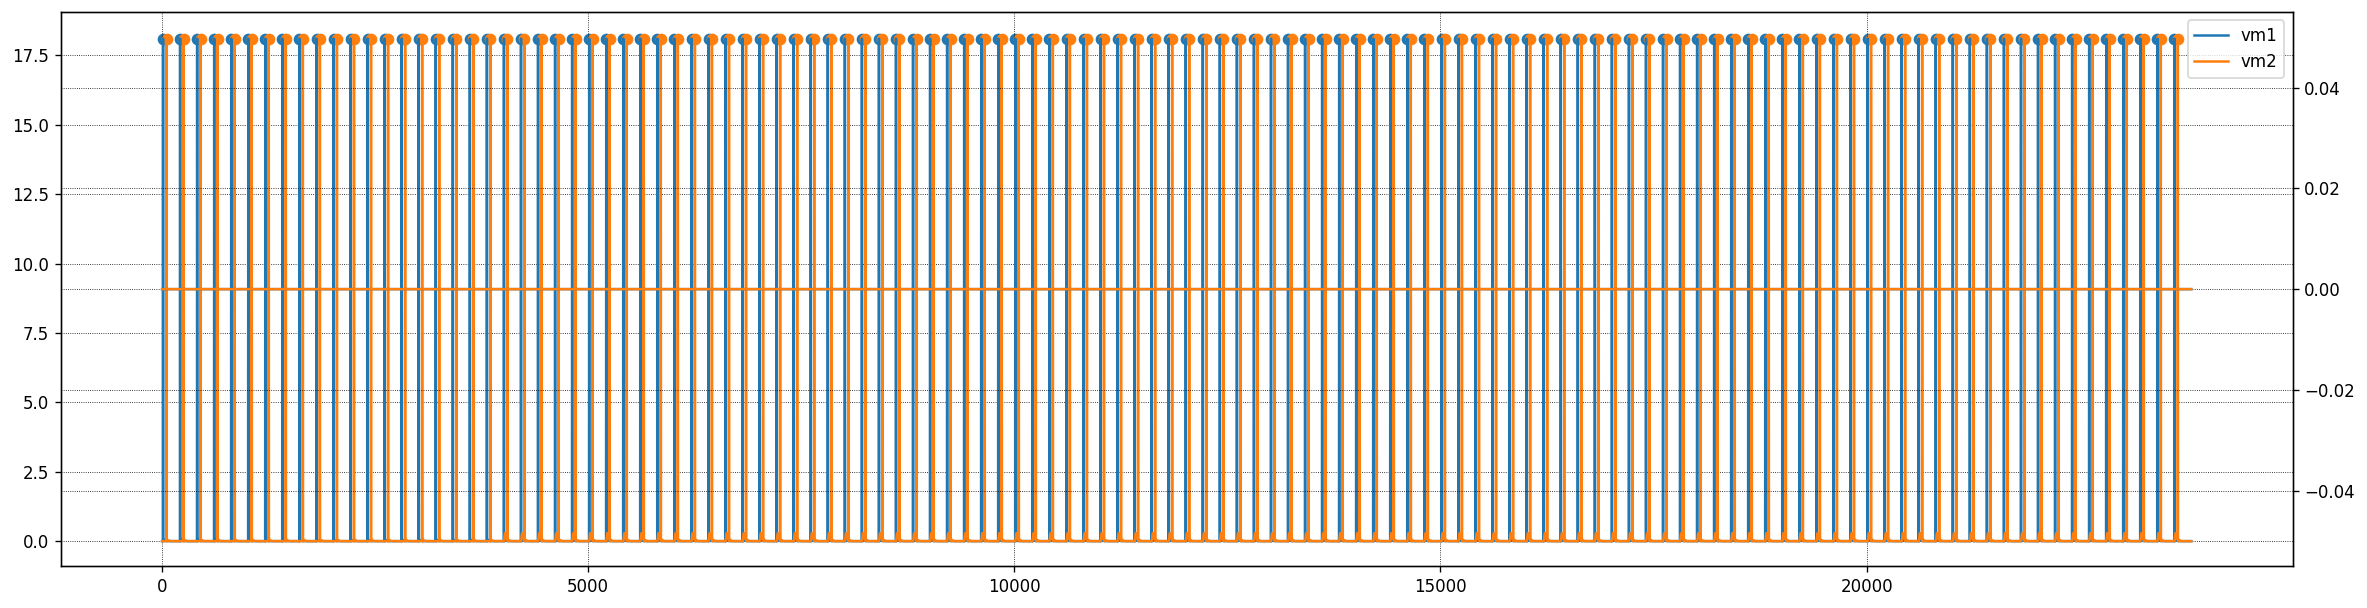

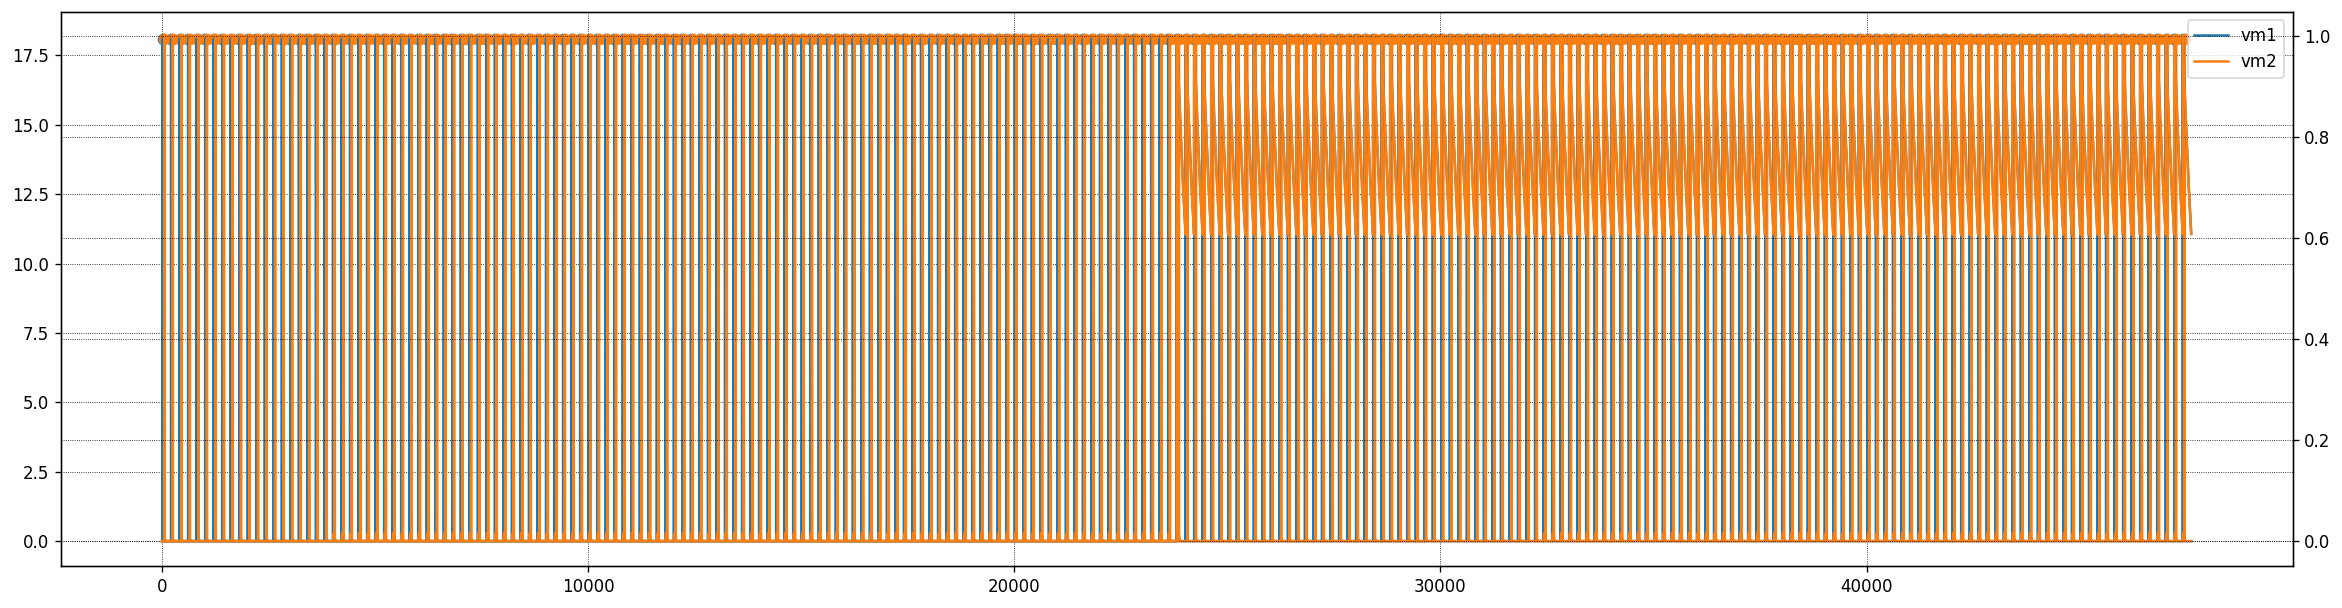

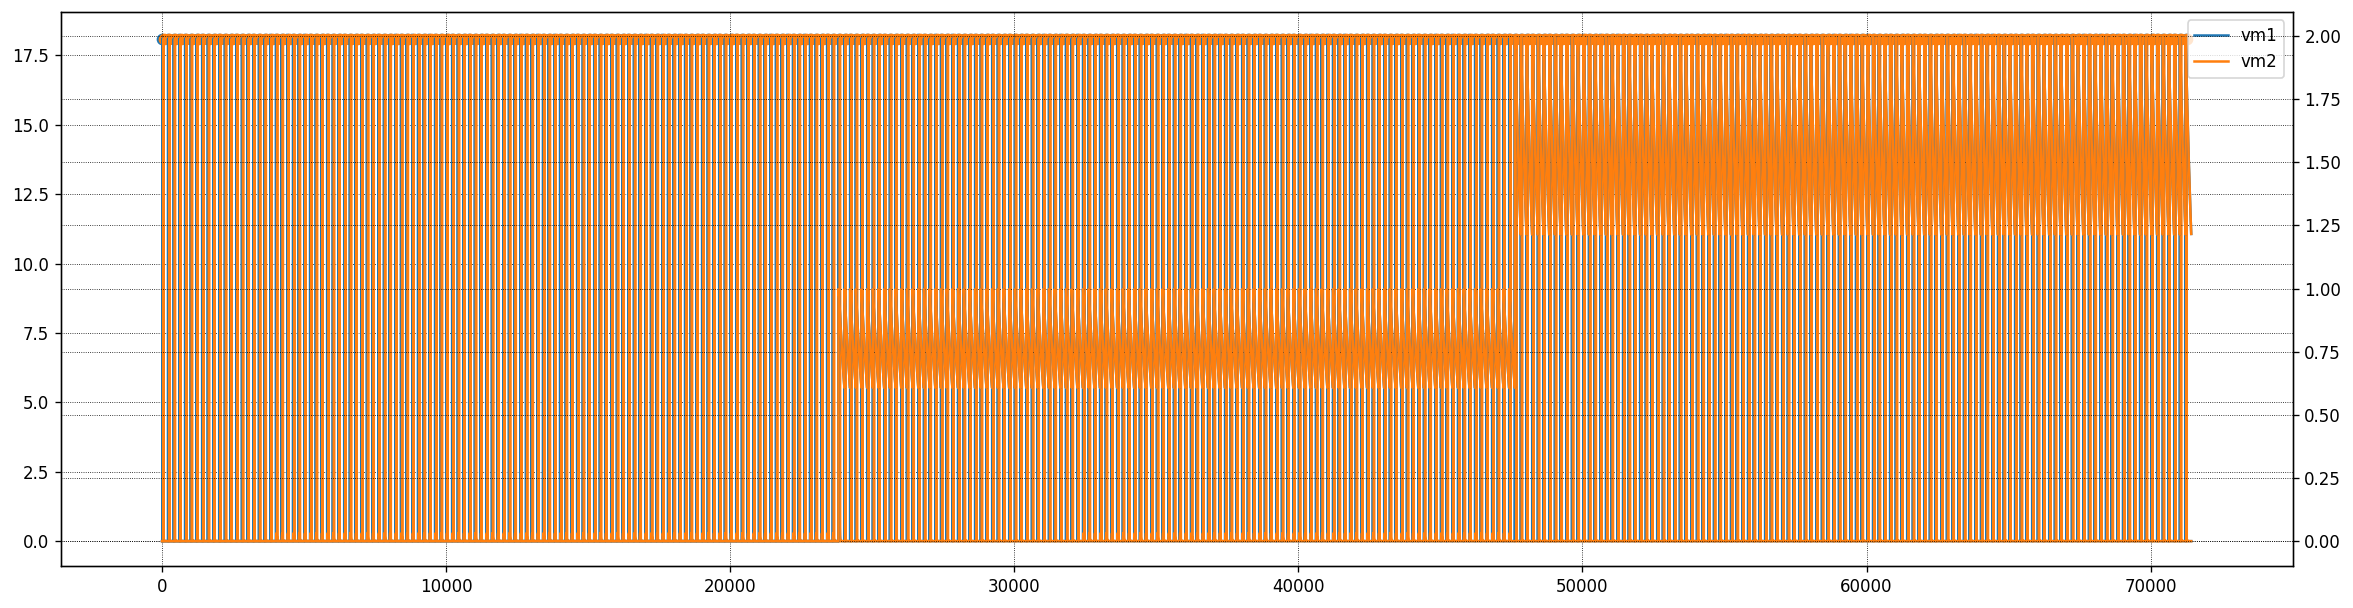

In [11]:
def simulate_foobar(params):
    
    nest.ResetKernel()
    nest.set_verbosity("M_ALL")
    nest.SetKernelStatus({
        'resolution': params['dt'],
        'print_time': params['print_simulation_progress'],
        'local_num_threads': n_threads,
        'rng_seed': params['seed']
    })
    
    neuron_1 = nest.Create(params['soma_model'], params=params['soma_params'])
    neuron_2 = nest.Create(params['soma_model'], params=params['soma_params'])
    
    # connect two neurons
    nest.Connect(neuron_1, neuron_2, syn_spec=params['syn_dict_ee'])
    
    # creation of spike generator
    time_neuron_1 = 10.
    time_neuron_2 = time_neuron_1 + params['DeltaT']
    
    training_steps = 120
    between_exc = 5*params['DeltaT']
    
    times_neuron_1 = [time_neuron_1+i*between_exc for i in range(training_steps)]
    times_neuron_2 = [time_neuron_2+i*between_exc for i in range(training_steps)]#[:10]
    
    # create the spike generators 
    # disable spike generator for the interval 'dis', to see the affect of stpd
    dis = 20
    spike_generator_1 = nest.Create('spike_generator', params={'spike_times': times_neuron_1})
    spike_generator_2 = nest.Create('spike_generator', params={'spike_times': times_neuron_2})
    
    # connect the spike generator 
    
    params['R_m_soma'] = params['soma_params']['tau_m'] / params['soma_params']['C_m']
    params['syn_dict_ex']['weight'] = psp_max_2_psc_max(params['J_EX_psp'], 
                                                               params['soma_params']['tau_m'], 
                                                               params['soma_params']['tau_syn1'], 
                                                               params['R_m_soma'])
    
    syn_dict_ff = {'receptor_type': 1, 'weight': params['syn_dict_ex']['weight'], 'delay': params['syn_dict_ex']['delay']}
    nest.Connect(spike_generator_1, neuron_1, syn_spec=syn_dict_ff)
    nest.Connect(spike_generator_2, neuron_2, syn_spec=syn_dict_ff)
    
    # record voltage neuron 1, neuron 2
    dap_mm_1 = nest.Create('multimeter', {"record_from": ["dAP_trace"]})
    nest.Connect(dap_mm_1, neuron_1)
    
    dap_mm_2 = nest.Create('multimeter', {"record_from": ["dAP_trace"]})
    nest.Connect(dap_mm_2, neuron_2)
    
    vm_1 = nest.Create('voltmeter')
    vm_2 = nest.Create('voltmeter')
    nest.Connect(vm_1, neuron_1)
    nest.Connect(vm_2, neuron_2)
    
    
    sd_1 = nest.Create('spike_recorder')
    nest.Connect(neuron_1, sd_1)
    
    sd_2 = nest.Create('spike_recorder')
    nest.Connect(neuron_2, sd_2)
    
    data = {}
    
    synColl = nest.GetConnections(synapse_model=synapse_model_name)
    assert len(synColl) == 1
    
    print('\n simulate')
    zs = [0.,1.,2.]
    weights_cs = []
    permanences_cs = []
    
    for z in zs:
    
        weights = []
        permanences = []
        last_sim_time = 0
        
        spike_generator_1.origin = nest.GetKernelStatus('biological_time')
        spike_generator_2.origin = nest.GetKernelStatus('biological_time')
        
        # connect two neurons
        synColl.set({'permanence': 1.}) 
    
        for i in range(training_steps):
    
            # change toward using the weight recorder, example:
            #wr = nest.Create('weight_recorder')
            #nest.CopyModel('stdp_synapse', 'stdp_synapse_rec', {'weight_recorder': wr})
    
            nest.SetStatus(neuron_1, {'dAP_trace':z})
            nest.SetStatus(neuron_2, {'dAP_trace':z})
    
            # simulate the network
            sim_time = times_neuron_1[i] - last_sim_time 
            nest.Simulate(sim_time)
            last_sim_time = times_neuron_1[i]
    
            w_after = synColl.weight
            p_after = synColl.permanence
            weights.append(w_after)
            permanences.append(p_after)
    
            
        fig, ax = plt.subplots(figsize=(24,6))
        ax.plot(nest.GetStatus(vm_1)[0]['events']["times"], nest.GetStatus(vm_1)[0]['events']["V_m"], label="vm1")
        max_V_m = np.amax(nest.GetStatus(vm_1)[0]['events']["V_m"])
        ax.scatter(nest.GetStatus(sd_1)[0]['events']['times'], max_V_m * np.ones_like(nest.GetStatus(sd_1)[0]['events']['times']))
        ax.plot(nest.GetStatus(vm_2)[0]['events']["times"], nest.GetStatus(vm_2)[0]['events']["V_m"], label="vm2")
        ax.scatter(nest.GetStatus(sd_2)[0]['events']['times'], max_V_m * np.ones_like(nest.GetStatus(sd_2)[0]['events']['times']))
        ax.legend()
        ax_ = ax.twinx()
        ax_.plot(nest.GetStatus(dap_mm_1)[0]['events']["times"], nest.GetStatus(dap_mm_1)[0]['events']["dAP_trace"], label="dAP")
        ax_.plot(nest.GetStatus(dap_mm_2)[0]['events']["times"], nest.GetStatus(dap_mm_2)[0]['events']["dAP_trace"], label="dAP")
        
        fig.savefig("/tmp/foo" + str(z) + ".png")
            
        weights_cs.append(weights)
        permanences_cs.append(permanences)
    
    # store postprocessed
    params['zs'] = zs

    data["weights_cs"] = weights_cs
    data["permanences_cs"] = permanences_cs
    
    return data

data = simulate_foobar(params)

DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0.
DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0 to DejaVu Sans ('/home/charl/.local/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0.
DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0 to DejaVu Sans ('/home/charl/.local/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:findfont: Matching STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0.
DEBUG:findfont: Matching STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0 to STIXGeneral ('/home/charl/.local/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.

---------------------------------


DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0 to DejaVu Sans ('/home/charl/.local/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0 to DejaVu Sans ('/home/charl/.local/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


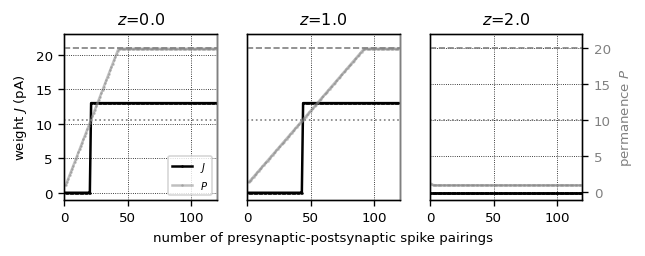

In [12]:
def plot_foobar(data, params):
    
    # plot recorded data
    # ------------------
    
    # plot settings 
    fig_size = (5.2, 2.)
    plt.rcParams['font.size'] = 8
    plt.rcParams['legend.fontsize'] = 6
    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['text.usetex'] = False

    ms = 0.5
    alpha = 0.5
    lw_hline = 1.
    
    #################
    # visualize data
    # ---------------
    gs = mpl.gridspec.GridSpec(1, 3, right=0.92, left=0.09, bottom=0.2, top=0.89, wspace=0.2, hspace=0.2)
    
    # data for Ic=0
    # -------------
    ax1 = plt.subplot(gs[0,0])
    
    training_steps = len(data["weights_cs"][0])
    num_pulses = np.arange(training_steps)
    lns1 = ax1.plot(num_pulses, data["weights_cs"][0], '-o', ms=ms, color='black', label=r'$J$')
    
    #plt.ylabel('weight ($\mu$S)')
    ax1.set_xlim(0, training_steps)
    ax1.set_ylim(-1, params["syn_dict_ee"]['Wmax']+10)
    #ax1.set_title(r'dAP rate $\nu_\mathsf{d}$=%0.1f' % zs[0])
    ax1.set_title(r'$z$=%0.1f' % params['zs'][0])
    ax1.set_ylabel(r'weight $J$ (pA)')
    
    ax2 = ax1.twinx()
    lns2 = ax2.plot(num_pulses, data["permanences_cs"][0], '-o', ms=ms, color='grey', alpha=alpha, label=r'$P$')
    if 'permanence_threshold' in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['permanence_threshold'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dotted')
    if 'th_perm' in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['th_perm'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dotted')

    if "permanence_max" in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['permanence_max'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dashed')
        ax2.set_ylim(-1, params["syn_dict_ee"]['permanence_max']+2)

    if "Pmax" in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['Pmax'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dashed')    
        ax2.set_ylim(-1, params["syn_dict_ee"]['Pmax']+2)

    
    ax2.tick_params(axis='y', labelcolor='grey')
    #ax2.set_yticklabels([])
    ax2.set_yticks([])
    ax2.spines['right'].set_color('grey')
    
    # add legends
    lns = [lns1[0],lns2[0]]
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='lower right')
    
    # data for Ic=1
    # -------------
    ax1 = plt.subplot(gs[0,1])
    
    ax1.plot(num_pulses, data["weights_cs"][1], '-o', ms=ms, color='black', label='weight')
    
    ax1.set_ylim(-1, params["syn_dict_ee"]['Wmax']+10)
    ax1.set_xlim(0, training_steps)
    #ax1.set_title(r'dAP rate $\nu_\mathsf{d}$=%0.1f' % params['zs'][1])
    ax1.set_title(r'$z$=%0.1f' % params['zs'][1])
    ax1.set_xlabel('number of presynaptic-postsynaptic spike pairings')
    ax1.set_yticks([])
    
    ax2 = ax1.twinx()
    ax2.plot(num_pulses, data["permanences_cs"][1], '-o', ms=ms, color='grey', alpha=alpha, label='permanence')
    if 'permanence_threshold' in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['permanence_threshold'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dotted')
    if 'th_perm' in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['th_perm'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dotted')

    if "permanence_max" in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['permanence_max'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dashed')
        ax2.set_ylim(-1, params["syn_dict_ee"]['permanence_max']+2)

    if "Pmax" in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['Pmax'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dashed')    
        ax2.set_ylim(-1, params["syn_dict_ee"]['Pmax']+2)
    
    
    ax2.tick_params(axis='y', labelcolor='grey')
    ax2.set_yticks([])
    ax2.spines['right'].set_color('grey')
    
    # data for Ic=2
    # -------------
    ax1 = plt.subplot(gs[0,2])
    
    ax1.plot(num_pulses, data["weights_cs"][2], '-o', ms=ms, color='black', label='weight')
    
    ax1.set_ylim(-1, params["syn_dict_ee"]['Wmax']+10)
    ax1.set_xlim(0, training_steps)
    #ax1.set_title(r'dAP rate $\nu_\mathsf{d}$=%0.1f' % params['zs'][2])
    ax1.set_title(r'$z$=%0.1f' % params['zs'][2])
    ax1.set_yticks([])
    
    ax2 = ax1.twinx()
    ax2.plot(num_pulses, data["permanences_cs"][2], '-o', ms=ms, color='grey', alpha=alpha, label=r'$P$')
    if 'permanence_threshold' in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['permanence_threshold'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dotted')
    if 'th_perm' in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['th_perm'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dotted')
    if "permanence_max" in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['permanence_max'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dashed')
        ax2.set_ylim(-1, params["syn_dict_ee"]['permanence_max']+2)

    if "Pmax" in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['Pmax'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dashed')    
        ax2.set_ylim(-1, params["syn_dict_ee"]['Pmax']+2)

    ax2.tick_params(axis='y', labelcolor='grey')
    ax2.set_ylabel(r"permanence $P$", color="grey")
    #ax2.spines['right'].set_color('grey')
    
    print('---------------------------------')
    path = '.'
    fname = 'plasticity_dynamics'
    #print("save %s/%s.pdf" % (path, fname))
    #plt.savefig("/tmp/%s.pdf" % fname)
    plt.savefig("/tmp/%s.png" % fname)

plot_foobar(data, params)

## Experiment 3: Network sequence generation

Running psc test simulation!
### simulating network


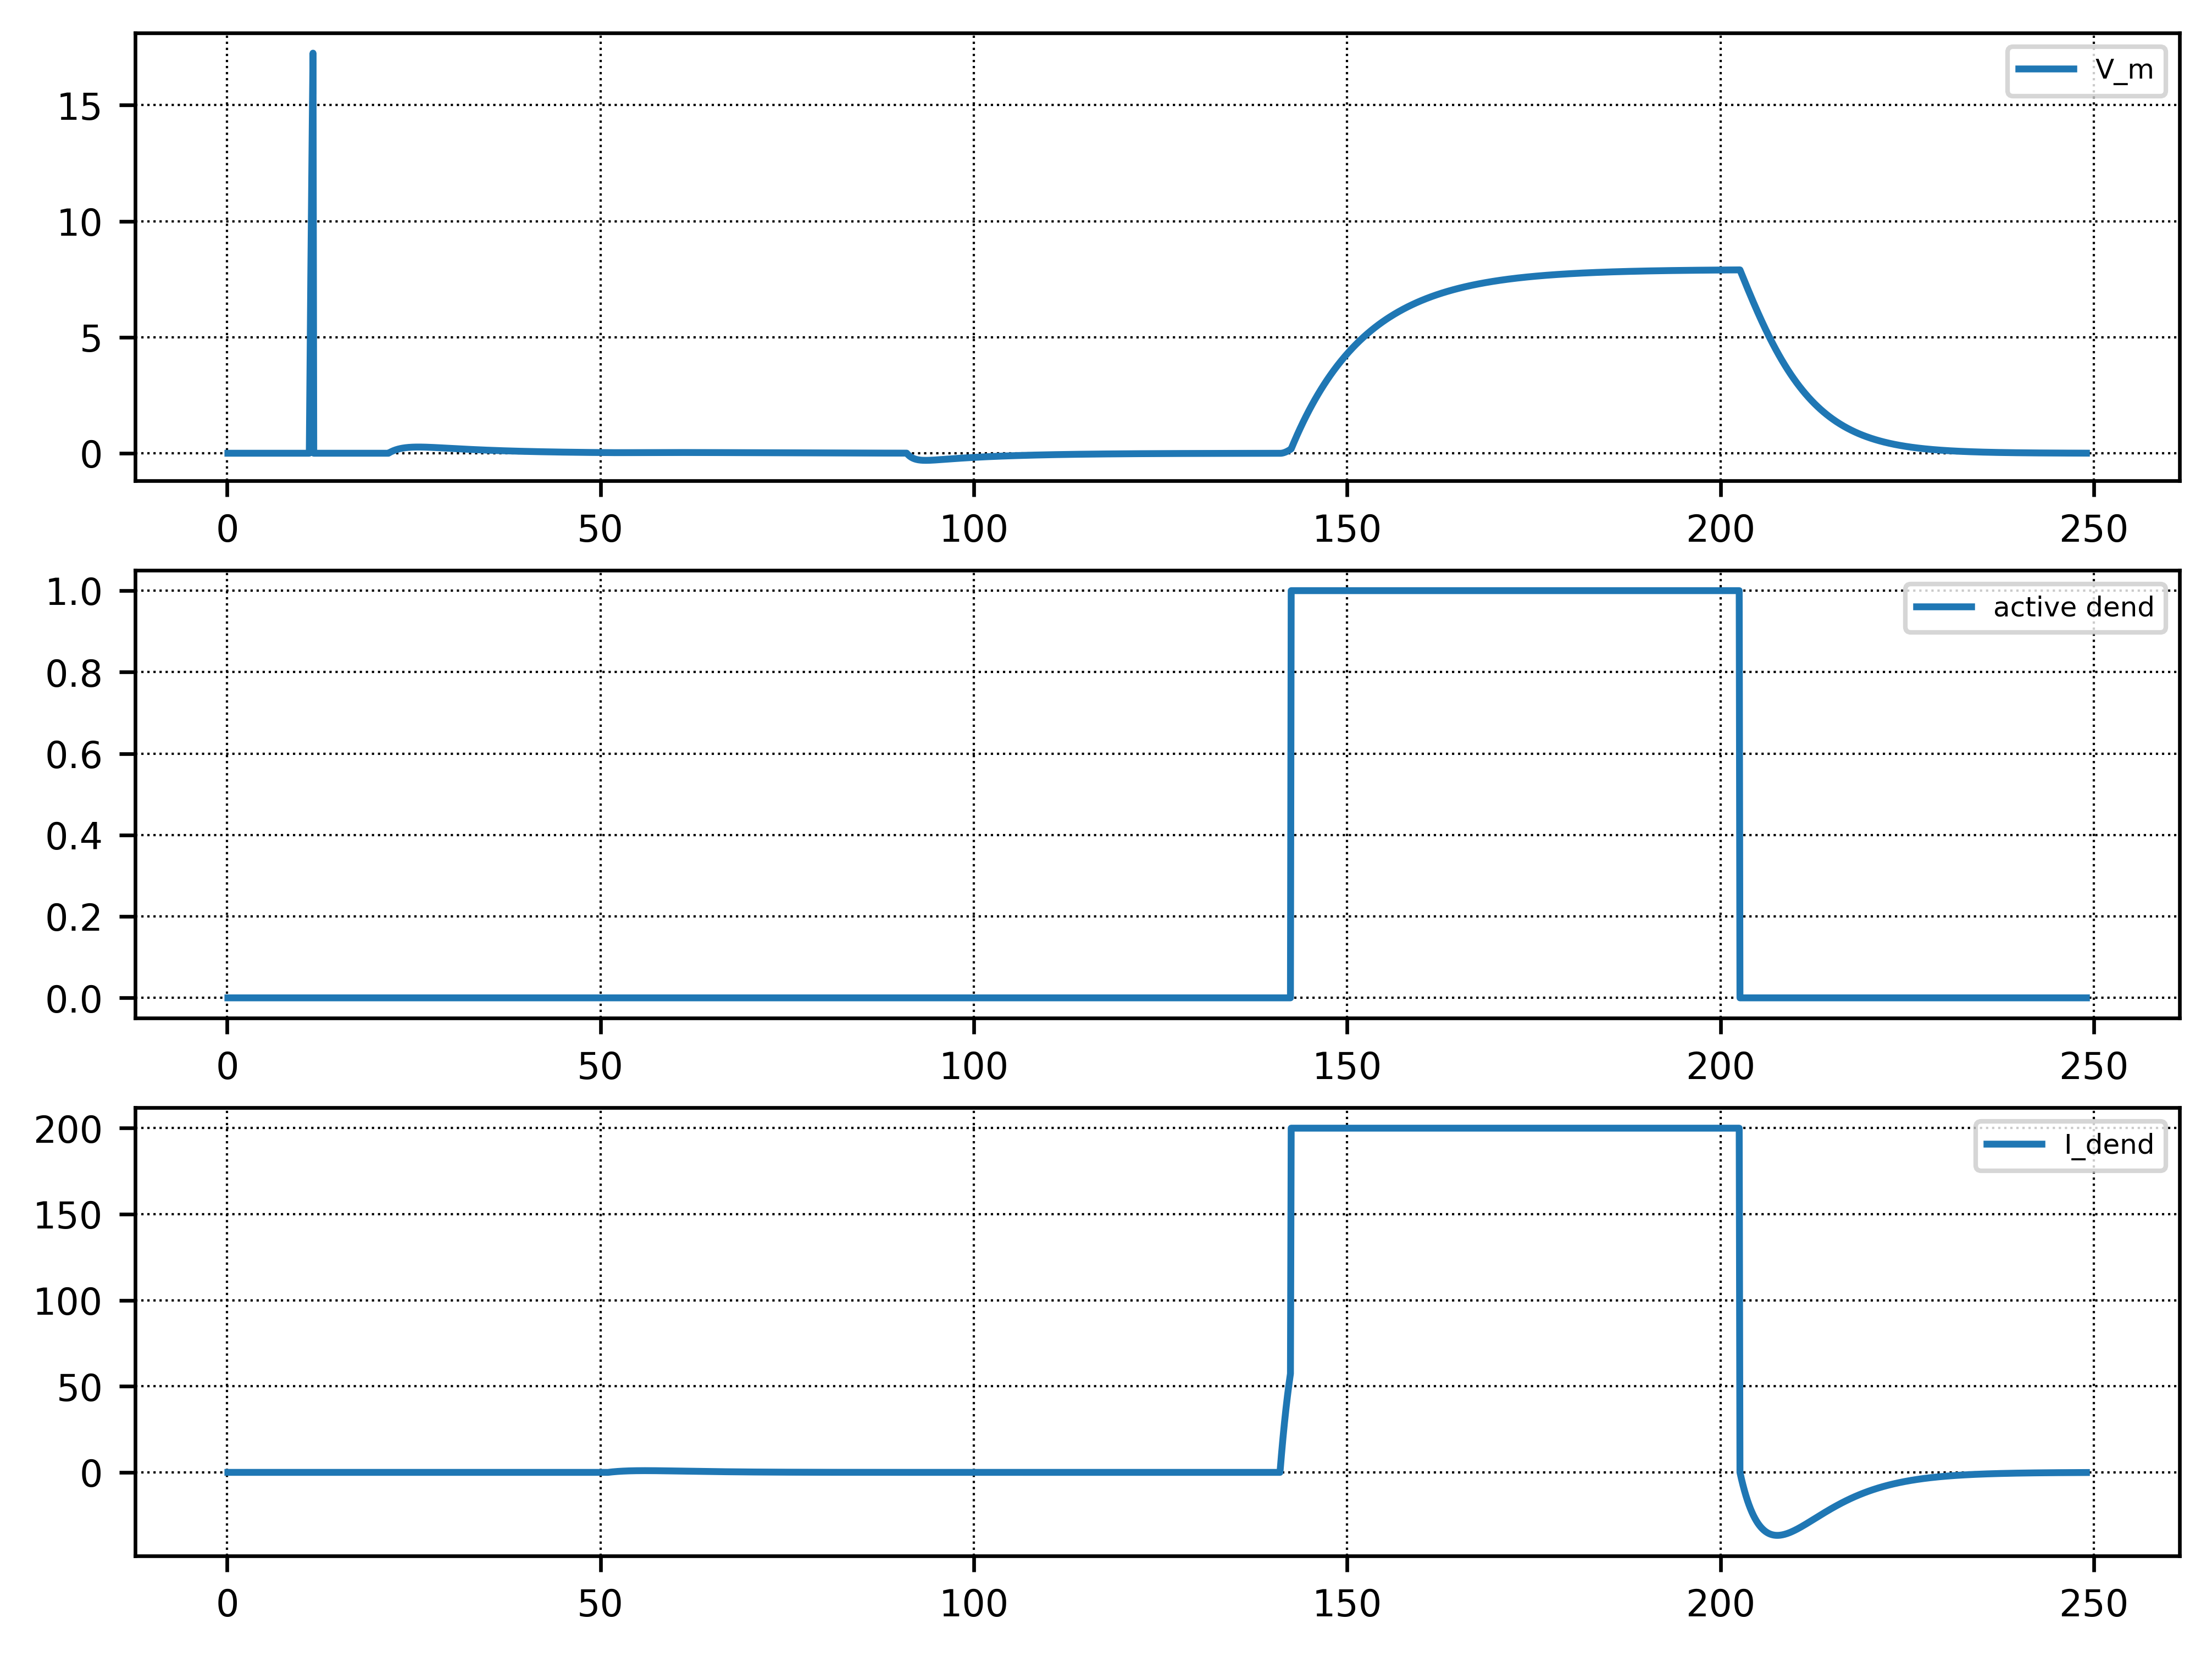

In [13]:
def create_active_dendrite_parameters():
    DELAY = 0.1
    
    p = para.ParameterSpace({})
    
    p['dt'] = 0.1                                  # simulation time resolution (ms)
    p['print_simulation_progress'] = True         # print the time progress.
    
    # neuron parameters of the excitatory neurons
    p['soma_model'] = neuron_model_name
    p['soma_params'] = {}
    p['soma_params']['C_m'] = 250.        # membrane capacitance (pF)
    p['soma_params']['E_L'] = 0.          # resting membrane potential (mV)
    # p['soma_params']['I_e'] = 0.        # external DC currents (pA)
    p['soma_params']['V_m'] = 0.          # initial potential (mV)
    p['soma_params']['V_reset'] = 0.      # reset potential (mV)
    p['soma_params']['V_th'] = 20.        # spike threshold (mV)
    p['soma_params']['t_ref'] = 10.       # refractory period
    p['soma_params']['tau_m'] = 10.       # membrane time constant (ms)
    p['soma_params']['tau_syn1'] = 2.     # synaptic time constant: external input (receptor 1)
    p['soma_params']['tau_syn2'] = 5.     # synaptic time constant: dendrtic input (receptor 2)
    p['soma_params']['tau_syn3'] = 1.     # synaptic time constant: inhibitory input (receptor 3)
    # dendritic action potential
    p['soma_params']['I_p'] = 200. # current clamp value for I_dAP during a dendritic action potenti
    p['soma_params']['tau_dAP'] = 60.       # time window over which the dendritic current clamp is active
    p['soma_params']['theta_dAP'] = 59.        # current threshold for a dendritic action potential
    
    p['soma_params']['I_dend_incr'] = 2.71 / (p['soma_params']['tau_syn2'])
    
    
    p['fixed_somatic_delay'] = 2          # this is an approximate time of how long it takes the soma to fire
                                          # upon receiving an external stimulus 
    
        
    
    # neuron parameters for the inhibitory neuron
    p['inhibit_model'] = 'iaf_psc_exp'
    p['inhibit_params'] = {}
    p['inhibit_params']['C_m'] = 250.         # membrane capacitance (pF)
    p['inhibit_params']['E_L'] = 0.           # resting membrane potential (mV)
    p['inhibit_params']['I_e'] = 0.           # external DC currents (pA)
    p['inhibit_params']['V_m'] = 0.           # initial potential (mV)
    p['inhibit_params']['V_reset'] = 0.       # reset potential (mV)
    p['inhibit_params']['V_th'] = 15.         # spike threshold (mV)
    p['inhibit_params']['t_ref'] = 2.0        # refractory period
    p['inhibit_params']['tau_m'] = 5.         # membrane time constant (ms)
    p['inhibit_params']['tau_syn_ex'] = .5    # synaptic time constant of an excitatory input (ms) 
    p['inhibit_params']['tau_syn_in'] = 1.65  # synaptic time constant of an inhibitory input (ms)
    
        
        
        
    # synaptic parameters
    p['J_EX_psp'] = 1.1 * p['soma_params']['V_th']     # somatic PSP as a response to an external input
    p['J_IE_psp'] = 1.2 * p['inhibit_params']['V_th']  # inhibitory PSP as a response to an input from E neuron
    p['J_EI_psp'] = -2 * p['soma_params']['V_th']      # somatic PSP as a response to an inhibitory input
    p['convergence'] = 5
    
    
    
    
    # parameters for setting up the network  
    p['M'] = 6                   # number of subpopulations
    p['n_E'] = 150               # number of excitatory neurons per subpopulation
    p['n_I'] = 1                 # number of inhibitory neurons per subpopulation
    p['L'] = 1                   # number of subpopulations that represents one sequence element
    p['pattern_size'] = 20       # sparse set of active neurons per subpopulation
    
    # connection details
    p['rule'] = 'fixed_indegree'                          
    p['connection_prob'] = 0.2
    
    # synaptic parameters
    p['J_EX_psp'] = 1.1 * p['soma_params']['V_th']     # somatic PSP as a response to an external input
    p['J_EI_psp'] = -2 * p['soma_params']['V_th']      # somatic PSP as a response to an inhibitory input
    p['convergence'] = 5
    
    # parameters for ee synapses (stdsp)
    p['syn_dict_ee'] = {}
    p['permanence_min'] = 0.
    p['permanence_max'] = 8.


    
    p['calibration'] = 0.
    p['syn_dict_ee']['weight'] = 0.01                    # synaptic weight
    p['syn_dict_ee']['synapse_model'] = synapse_model_name  # synapse model
    if "synapse_nestml" in synapse_model_name:
        p['syn_dict_ee']['permanence_threshold'] = 10.                    # synapse maturity threshold
        p['syn_dict_ee']['tau_pre_trace'] = 20.                   # plasticity time constant (potentiation)
    else:
        p['syn_dict_ee']['th_perm'] = 10.                    # synapse maturity threshold
        p['syn_dict_ee']['tau_plus'] = 20.                   # plasticity time constant (potentiation)
    p['syn_dict_ee']['delay'] = 2.                       # dendritic delay 
    p['syn_dict_ee']['receptor_type'] = 2                # receptor corresponding to the dendritic input
    p['syn_dict_ee']['lambda_plus'] = 0.08               # potentiation rate
    p['syn_dict_ee']['zt'] = 1.                          # target dAP trace
    p['syn_dict_ee']['lambda_h'] = 0.014                 # homeostasis rate
    p['syn_dict_ee']['Wmax'] = 1.1 * p['soma_params']['theta_dAP'] / p['convergence']   # Maximum allowed weight
    if "synapse_nestml" in synapse_model_name:
        p['syn_dict_ee']['permanence_max'] = 20.                       # Maximum allowed permanence
        p['syn_dict_ee']['permanence_min'] = 1.                        # Minimum allowed permanence
    else:
        p['syn_dict_ee']['Pmax'] = 20.                       # Maximum allowed permanence
        p['syn_dict_ee']['Pmin'] = 1.                        # Minimum allowed permanence
    p['syn_dict_ee']['lambda_minus'] = 0.0015            # depression rate
    if "synapse_nestml" in synapse_model_name:
        p['syn_dict_ee']['dt_min'] = 4.                     # minimum time lag of the STDP window
    else:
        p['syn_dict_ee']['dt_min'] = -4.                     # minimum time lag of the STDP window
    p['inh_factor'] = 7.
    
    # parameters of EX synapses (external to soma of E neurons)
    p['conn_dict_ex'] = {}
    p['syn_dict_ex'] = {}
    p['syn_dict_ex']['receptor_type'] = 1                    # receptor corresponding to external input
    p['syn_dict_ex']['delay'] = DELAY                        # dendritic delay
    p['conn_dict_ex']['rule'] = 'all_to_all'                 # connection rule
    
    # parameters of EdX synapses (external to dendrite of E neurons) 
    p['conn_dict_edx'] = {}
    p['syn_dict_edx'] = {}
    p['syn_dict_edx']['receptor_type'] = 2                    # receptor corresponding to the dendritic input
    p['syn_dict_edx']['delay'] = DELAY                        # dendritic delay
    p['syn_dict_edx']['weight'] = 1.4 * p['soma_params']['theta_dAP']
    p['conn_dict_edx']['rule'] = 'fixed_outdegree'            # connection rule
    p['conn_dict_edx']['outdegree'] = p['pattern_size'] + 1   # outdegree
    
    # parameters for IE synapses 
    p['syn_dict_ie'] = {}
    p['conn_dict_ie'] = {}
    p['syn_dict_ie']['synapse_model'] = 'static_synapse'     # synapse model
    p['syn_dict_ie']['delay'] = DELAY                        # dendritic delay
    p['conn_dict_ie']['rule'] = 'fixed_indegree'             # connection rule
    p['conn_dict_ie']['indegree'] = 5                        # indegree 
    
    # parameters for EI synapses
    p['syn_dict_ei'] = {}
    p['conn_dict_ei'] = {}
    p['syn_dict_ei']['synapse_model'] = 'static_synapse'     # synapse model
    p['syn_dict_ei']['delay'] = DELAY                        # dendritic delay
    p['syn_dict_ei']['receptor_type'] = 3                    # receptor corresponding to the inhibitory input  
    p['conn_dict_ei']['rule'] = 'fixed_indegree'             # connection rule
    p['conn_dict_ei']['indegree'] = 20                       # indegree
    
    # stimulus parameters
    p['DeltaT'] = 40.                     # inter-stimulus interval
    p['excitation_start'] = 30.           # time at which the external stimulation begins
    p['time_dend_to_somatic'] = 20.       # time between the dAP activation and the somatic activation (only used if sparse_first_char is True)   
    p['DeltaT_cue'] = 80.                 # inter-cue interval during replay
    
    # simulation parameters 
    p['dt'] = 0.1                                  # simulation time resolution (ms)
    p['overwrite_files'] = True                    # if True, data will be overwritten,
                                                   # if False, a NESTError is raised if the files already exist
    p['seed'] = para.ParameterRange([1,2,3,4,5])   # seed for NEST
    p['print_simulation_progress'] = True         # print the time progress.
    p['pad_time'] = 5.
    p['idend_recording_interval'] = 10 * p['dt']   # dendritic current recording resolution
    p['idend_record_time'] = 8.                    # time interval after the external stimulation at which the dendritic current is recorded
    p['evaluate_performance'] = True               # if turned on, we monitor the dendritic current at a certain time steps
                                                   # during the simulation. This then is used for the prediction performance assessment
    p['evaluate_replay'] = False                     
    p['record_idend_last_episode'] = True          # used for debugging, if turned on we record the dendritic current of all neurons
                                                   # this can consume too much memory
    p['store_connections'] = False              
    p['load_connections'] = False
    p['sparse_first_char'] = False                 # if turned on, the dAP of a subset of neurons in the subpopulation representing 
                                                   # first sequence elements is activated externally 
    p['active_weight_recorder'] = False            # if turned on, the weights are recorded every presynaptic spike
    
    # task parameters
    p['task'] = {}
    p['task']['task_name'] = 'hard_coded'          # name of the task
    p['task']['task_type'] = 1                     # this chooses between three hard coded sequence sets (see ./utils.py)
    p['task']['vocab_size'] = 6                   # vocabulary size
    p['task']['seed'] = 111                        # seed number
    p['task']['store_training_data'] = True        # if turned on, the sequence set is stored in directory defined in dict data_path
    if p['task']['task_name'] != 'hard_coded':
        p['task']['num_sequences'] = 2             # number of sequences per sequence set
        p['task']['num_sub_seq'] = 2               # if task_name == 'high_order', 
                                                   # it sets the number of sequences with same shared subsequence
        p['task']['length_sequence'] = 6           # number of elements per sequence
        p['task']['replace'] = False               # random choice of characters with replacement
    
    # setup the training loop  
    p['learning_episodes'] = 42 #XXX: was 85                     # total number of training episodes ('repetitions of the sequence sets')
    p['episodes_to_testing'] = 1                   # number of episodes after which we measure the prediction perfomance

    if "synapse_nestml" not in synapse_model_name:
        p['mu_plus']= 0.0 
        p['mu_minus']= 0.0

    
    return p



params = create_active_dendrite_parameters()

run_psc_test(params)



Save training data to training_data

Initialising model and simulation...

#### postsynaptic potential ####
PSP maximum J_EX psp:  22.000000 mV
PSP maximum J_IE psp:  0.900000 mV
PSP maximum J_EI psp:  -40.000000 mV

#### postsynaptic current ####
PSC maximum J_EX:  4112.209148 pA
PSC maximum J_IE:  581.197349 pA
PSC maximum J_EI:  -12915.496650 pA
Model parameters: {'dt': 0.1, 'print_simulation_progress': True, 'soma_model': 'iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml__with_stdsp610c8a79f7f14886a9dbe3946c4b2740_synapse_nestml', 'soma_params': {'C_m': 250.0, 'E_L': 0.0, 'V_m': 0.0, 'V_reset': 0.0, 'V_th': 20.0, 't_ref': 10.0, 'tau_m': 10.0, 'tau_syn1': 2.0, 'tau_syn2': 5.0, 'tau_syn3': 1.0, 'I_p': 200.0, 'tau_dAP': 60.0, 'theta_dAP': 59.0, 'I_dend_incr': 0.542}, 'fixed_somatic_delay': 2, 'inhibit_model': 'iaf_psc_exp', 'inhibit_params': {'C_m': 250.0, 'E_L': 0.0, 'I_e': 0.0, 'V_m': 0.0, 'V_reset': 0.0, 'V_th': 15.0, 't_ref': 2.0, 'tau_m': 5.0, 'tau_syn

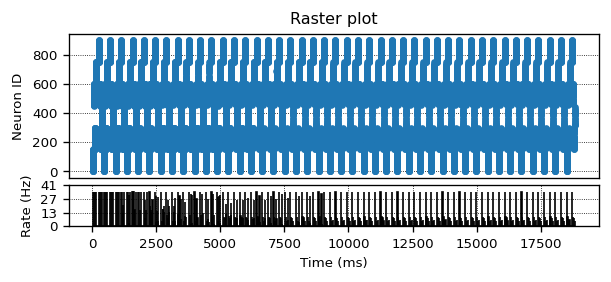

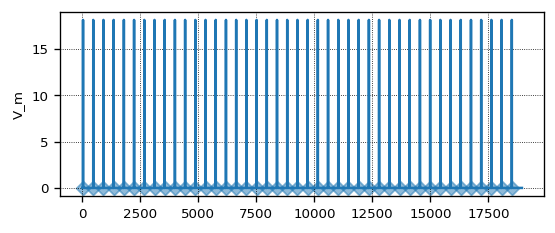

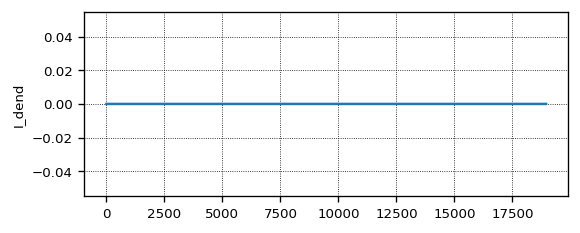

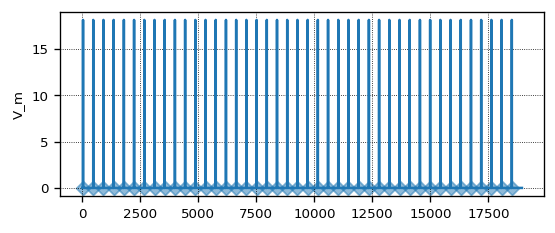

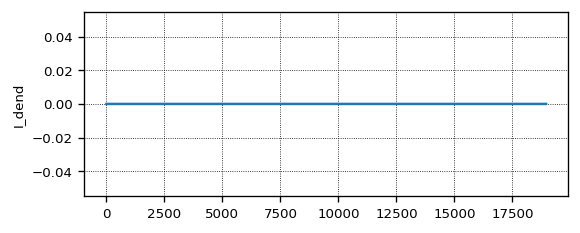

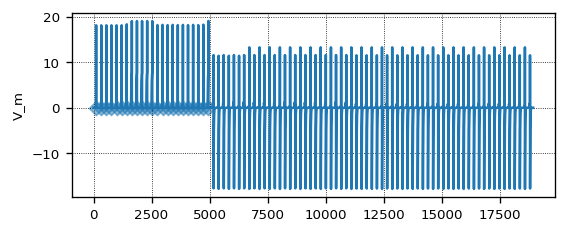

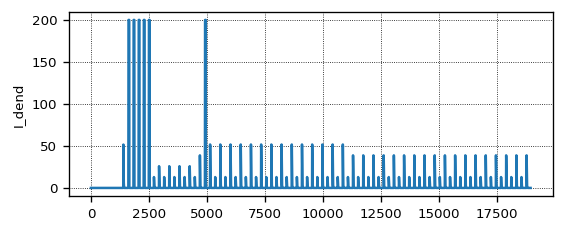

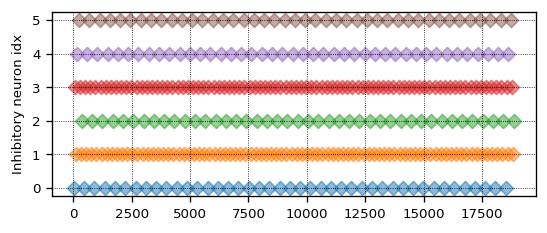

In [14]:
# experiments/sequence_learning_and_prediction/local_simulation.py

def generate_sequences(params, fname):
    """Generate sequence of elements using three methods:
    1. randomly drawn elements from a vocabulary
    2. sequences with transition matrix
    3. higher order sequences: sequences with shared subsequences
    4. hard coded sequences

    Parameters
    ----------
    params : dict
        dictionary contains task parameters
    fname       : str

    Returns
    -------
    sequences: list
    test_sequences: list
    vocabulary: list
    """

    task_name = params['task_name']
    task_type = params['task_type']
 
    # set of characters used to build the sequences
    vocabulary = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                  'U', 'V', 'W', 'X', 'Y', 'Z'][:params['vocab_size']]
    sequences = []

    # create high order sequences, characters are drawn without replacement
    if task_name == "high_order":

        if (params['num_sequences'] % params['num_sub_seq'] != 0):
            raise ZeroDivisionError(
                'for high order sequences number of sequences needs ("num_sequences") to be divisible by num_sub_seq')

        num_sequences_high_order = int(params['num_sequences'] / params['num_sub_seq'])
        for i in range(num_sequences_high_order):
            characters_sub_seq = copy.copy(vocabulary)
            sub_seq = random.sample(characters_sub_seq, params["length_sequence"] - 2)
            for char in sub_seq:
                characters_sub_seq.remove(char)

            for j in range(params['num_sub_seq']):
                # remove the characters that were chosen for the end and the start of the sequence
                # this is to avoid sequences with adjacent letters of the same kind
                # we will add this feature to the code asap 
                end_char = random.sample(characters_sub_seq, 1)
                characters_sub_seq.remove(end_char[0])

                start_char = random.sample(characters_sub_seq, 1)
                characters_sub_seq.remove(start_char[0])

                sequence = start_char + sub_seq + end_char
                sequences.append(sequence)

                # randomly shuffled characters
    elif task_name == "random":
        sequences = [random.sample(vocabulary, length_seq) for _ in range(params['num_sequences'])]

    # create sequences using matrix transition 
    elif task_name == "structure":
        matrix_transition = defaultdict(list)
        for char in vocabulary:
            x = np.random.choice(2, len(vocabulary), p=[0.2, 0.8])
            matrix_transition[char] = x / sum(x)

        for _ in range(params['num_sequences']):
            sequence = random.sample(vocabulary, 1)
            last_char = sequence[-1]
            for _ in range(length_seq - 1):
                sequence += np.random.choice(vocabulary, 1, p=matrix_transition[last_char])[0]
                last_char = sequence[-1]

            sequences += [sequence]
    else:

        # hard coded sequences 
        if task_type == 1:
            sequences = [['A', 'D', 'B', 'E'], ['F', 'D', 'B', 'C']]
        elif task_type == 2:
            sequences = [['E', 'N', 'D', 'I', 'J'], ['L', 'N', 'D', 'I', 'K'], ['G', 'J', 'M', 'C', 'N'], 
                         ['F', 'J', 'M', 'C', 'I'], ['B', 'C', 'K', 'H', 'I'], ['A', 'C', 'K', 'H', 'F']]
        elif task_type == 3:
            sequences = [['E', 'N', 'D', 'I', 'J'], ['L', 'N', 'D', 'I', 'K'], ['G', 'J', 'M', 'E', 'N'], 
                         ['F', 'J', 'M', 'E', 'I'], ['B', 'C', 'K', 'B', 'I'], ['A', 'C', 'K', 'B', 'F']]
        else:
            sequences = [['A', 'D', 'B', 'G', 'H', 'E'], ['F', 'D', 'B', 'G', 'H', 'C']]

    # test sequences used to measure the accuracy 
    test_sequences = sequences

    fname = 'training_data'
    fname_voc = 'vocabulary'
    print("\nSave training data to %s" % (fname))
    np.save('%s' % os.path.join( fname), sequences)
    np.save('%s' % os.path.join( fname_voc), vocabulary)

    return sequences, test_sequences, vocabulary


def generate_reference_data(params):

    #############################################################
    # get network and training parameters 
    # ===========================================================
    p = copy.deepcopy(params)
    PS = copy.deepcopy(p)

    # parameter-set id from command line (submission script)
    PL = shtm.helper.parameter_set_list(PS) 
    params = PL[0]

    # start time 
    time_start = time.time()

    # ###############################################################
    # specify sequences
    # ===============================================================
    sequences, _, vocabulary = generate_sequences(params['task'], PL[0]['label'])

    # ###############################################################
    # create network
    # ===============================================================
    model_instance = Model(params, sequences, vocabulary)
    time_model = time.time()

    model_instance.create()
    time_create = time.time()

    # ###############################################################
    # connect the netwok
    # ===============================================================
    print("connect().....")

    model_instance.connect()
    print("connect()ed")
    time_connect = time.time()
    
    # store connections before learning
    print("Store connections.....")
    if params['store_connections']:
        model_instance.save_connections(fname='ee_connections_before')

    # ###############################################################
    # simulate the network
    # ===============================================================
    print("Simulating.....")

    model_instance.simulate()
    time_simulate = time.time()



    print("Store connections.....")
    
    # store connections after learning
    if True:#params['store_connections']:
        model_instance.save_connections(fname='ee_connections')

    print(
        '\nTimes of Rank {}:\n'.format(
            nest.Rank()) +
        '  Total time:          {:.3f} s\n'.format(
            time_simulate -
            time_start) +
        '  Time to initialize:  {:.3f} s\n'.format(
            time_model -
            time_start) +
        '  Time to create:      {:.3f} s\n'.format(
            time_create -
            time_model) +
        '  Time to connect:     {:.3f} s\n'.format(
            time_connect -
            time_create) +
        '  Time to simulate:    {:.3f} s\n'.format(
            time_simulate -
            time_connect))

    #
    # PLOTTING
    #

    nest.raster_plot.from_device(model_instance.spike_recorder_soma)
    fname_snip = str(time.time())
    plt.savefig("/tmp/nestml_raster_"+fname_snip + ".png")

    for gid in [1, 100, 200]:

        
        events = model_instance.spike_recorder_soma_.get()["events"]
        times = events["times"]
        senders = events["senders"]
        idx = np.where(senders == gid)[0]
        spike_times = events["times"][idx]

        events = model_instance.multimeter_vm_eval_.get()["events"]
        times = events["times"]
        senders = events["senders"]
        idx = np.where(senders == gid)[0]
        V_m = events["V_m"][idx]
        times = times[idx]
        assert len(times) > 100

        
        fig, ax = plt.subplots()
        ax.plot(times, V_m)
        ax.scatter(spike_times, np.zeros_like(spike_times), marker="D", alpha=.5)
        ax.set_ylabel("V_m")
        fig.savefig("/tmp/nestml_V_m_" + str(gid) + "_" + fname_snip + ".png")
    
        events = model_instance.multimeter_idend_eval_.get()["events"]
        times = events["times"]
        senders = events["senders"]
        idx = np.where(senders == gid)[0]
        I_dend = events["I_dend"][idx]
        times = times[idx]
        assert len(times) > 100
    
        fig, ax = plt.subplots()
        ax.plot(times, I_dend)
        ax.set_ylabel("I_dend")
        fig.savefig("/tmp/nestml_I_dend_"  + str(gid) + "_" + fname_snip + ".png")

    events = model_instance.spike_recorder_inh_.get()["events"]
    times = events["times"]
    senders = events["senders"]

    fig, ax = plt.subplots()

    for i, gid in enumerate(np.unique(senders)):
        idx = np.where(senders == gid)[0]
        spike_times = events["times"][idx]

        ax.scatter(spike_times, i * np.ones_like(spike_times), marker="D", alpha=.5)
    ax.set_ylabel("Inhibitory neuron idx")
    fig.savefig("/tmp/nestml_inhibitory_spikes_" + str(gid) + "_" + fname_snip + ".png")
        
    
    # print Ic
    #zs = np.array([nest.GetStatus(model_instance.exc_neurons)[i]['z'] for i in range(params['M']*params['n_E'])])
    #id_zs = np.where(zs>0.5)
    #print(zs[id_zs])

    # load spikes from reference data
    somatic_spikes = shtm.helper.load_spike_data(model_instance.data_path, 'somatic_spikes')
    idend_eval = shtm.helper.load_spike_data(model_instance.data_path, 'idend_eval')
    excitation_times = shtm.helper.load_data(model_instance.data_path, 'excitation_times')

    # get recoding times of dendriticAP
    idend_recording_times = shtm.helper.load_data(model_instance.data_path,  'idend_recording_times')
    characters_to_subpopulations = shtm.helper.load_data(model_instance.data_path,  'characters_to_subpopulations')

    seq_avg_errors, seq_avg_false_positives, seq_avg_false_negatives, _ = shtm.helper.compute_prediction_performance(somatic_spikes, idend_eval, idend_recording_times, characters_to_subpopulations, model_instance.sequences, model_instance.params)

    # get number of active neuron for each element in the sequence
    number_elements_per_batch = sum([len(seq) for seq in model_instance.sequences])
    start_time = excitation_times[-number_elements_per_batch] - 5 
    end_time = excitation_times[-1] + 5

    idx_times = np.where((np.array(excitation_times) > start_time) & (np.array(excitation_times) < end_time))  
    excitation_times_sel = np.array(excitation_times)[idx_times]

    num_active_neurons = shtm.helper.number_active_neurons_per_element(model_instance.sequences, somatic_spikes[:,1], somatic_spikes[:,0], excitation_times_sel, params['fixed_somatic_delay'])

    print("\n##### testing sequences with number of somatic spikes ")
    count_false_negatives = 0
    for i, (sequence, seq_counts) in enumerate(zip(model_instance.sequences, num_active_neurons)): 
        seq = ''
        for j, (char, counts) in enumerate(zip(sequence, seq_counts)):
            seq += str(char)+'('+ str(seq_counts[char])+')'.ljust(2)

            if j != 0 and seq_counts[char] > 0.5*params['n_E']:
                count_false_negatives += 1

        print("sequence %d: %s" % (i, seq))   

    print("False negative counts", count_false_negatives)   

    print("\n### Plasticity parameters")
    print("lambda plus: %0.4f" % params['syn_dict_ee']['lambda_plus'])
    print("lambda homeostasis: %0.4f" % params['syn_dict_ee']['lambda_h'])
    print("lambda minus: %0.4f" % model_instance.params['syn_dict_ee']['lambda_minus']) 
    print("inh factor:", params['inh_factor'])
    print("excitation step %0.1fms" % params['DeltaT']) #30-50  
    print("seed number: %d" % params['seed']) 
    print("number of learning episodes: %d" % params['learning_episodes'])

    return model_instance

model_instance = generate_reference_data(params)




In [15]:
# from: experiments/sequence_learning_and_prediction/prediction_performance_analysis.py

def analyse_prediction_performance(params, model_instance):
    PS = copy.deepcopy(params)
    PS_sel = copy.deepcopy(PS)
    compute_overlap = True
    
    PL = shtm.helper.parameter_set_list(PS_sel)
    
    # get training data
    sequences = shtm.helper.load_data('.', 'training_data')
    
    print("#### sequences used for training ### ")
    for i, sequence in enumerate(sequences): 
        seq = '' 
        for char in sequence:
            seq += str(char).ljust(2) 
        print("sequence %d: %s" % (i, seq))
    
    fname = 'prediction_performance'
    for cP, p in enumerate(PL):
    
        data = {}
    
        # get data path
        # load somatic spikes and dendritic current
        somatic_spikes = shtm.helper.load_spike_data(model_instance.data_path, 'somatic_spikes')
        idend_eval = shtm.helper.load_spike_data(model_instance.data_path,  'idend_eval')
    
        # load record and excitation times 
        print("Loading idend_recording_times from " + str(os.path.join(model_instance.data_path,  'idend_recording_times')))
        idend_recording_times = shtm.helper.load_data(model_instance.data_path,  'idend_recording_times')
        characters_to_subpopulations = shtm.helper.load_data(model_instance.data_path,  'characters_to_subpopulations')
        excitation_times = shtm.helper.load_data(model_instance.data_path,  'excitation_times')
    
        # compute prediction performance
        errors, false_positives, false_negatives, num_active_neurons = shtm.helper.compute_prediction_performance(somatic_spikes, idend_eval, idend_recording_times, characters_to_subpopulations, sequences, p)
    
        if compute_overlap:
            # sequences overlap
            sequences_overlap = shtm.helper.measure_sequences_overlap(sequences, somatic_spikes[:,1], somatic_spikes[:,0], excitation_times, p['fixed_somatic_delay'], p['learning_episodes'])
            data['overlap'] = sequences_overlap
    
        data['error'] = errors
        data['false_positive'] = false_positives
        data['false_negative'] = false_negatives
        data['rel_active_neurons'] = num_active_neurons/p['n_E']
        data['ep_num'] = p['episodes_to_testing'] * np.arange(int(p['learning_episodes']/p['episodes_to_testing'])+1)
    
        ep_to_sol = np.where(errors < 0.01)[0] 
        if len(ep_to_sol) == 0:
            print("number of episodes to convergence", p['learning_episodes'])
        else:    
            print("number of episodes to convergence", data['ep_num'][ep_to_sol][0])
    
        # save data
        print("Saving to " + str(os.path.join(model_instance.data_path, fname)))
        np.save("%s" % os.path.join(model_instance.data_path, fname), data)

    return data

data = analyse_prediction_performance(params, model_instance)

#### sequences used for training ### 
sequence 0: A D B E 
sequence 1: F D B C 
Loading idend_recording_times from 6a496b4be2d415cae8f3300e2dd2ed7e/idend_recording_times
#### Prediction performance ####
Sequence: ['A' 'D' 'B' 'E']
Error: 0.0
False positives: 0.0
False negatives: 0.0
Number of active neurons in E: 24
Number of active dendrites in E: 24
#### Prediction performance ####
Sequence: ['F' 'D' 'B' 'C']
Error: 0.0
False positives: 0.0
False negatives: 0.0
Number of active neurons in C: 21
Number of active dendrites in C: 21
number of episodes to convergence 19
Saving to 6a496b4be2d415cae8f3300e2dd2ed7e/prediction_performance
Loading idend_recording_times from 6a496b4be2d415cae8f3300e2dd2ed7e/idend_recording_times
#### Prediction performance ####
Sequence: ['A' 'D' 'B' 'E']
Error: 0.0
False positives: 0.0
False negatives: 0.0
Number of active neurons in E: 24
Number of active dendrites in E: 24
#### Prediction performance ####
Sequence: ['F' 'D' 'B' 'C']
Error: 0.0
False positiv

#### sequences used for training ### 
sequence 0: A D B E 
sequence 1: F D B C 


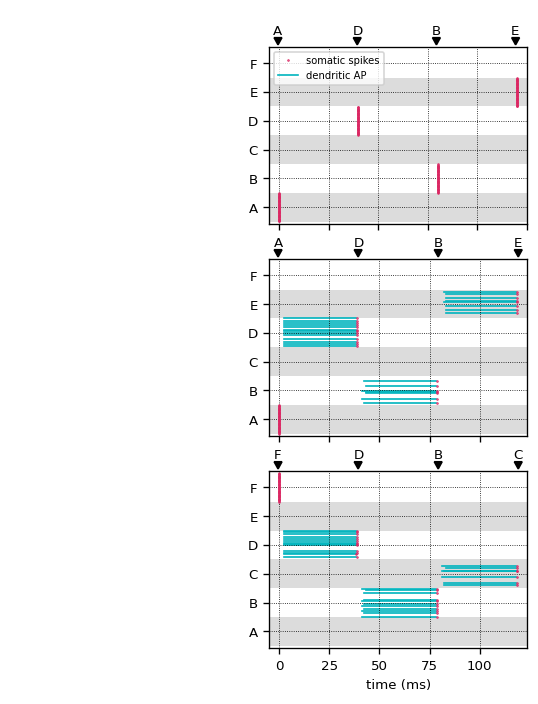

In [16]:
def load_data(path, fname):
    """Load data

    Parameters
    ----------
    path: str
    fname: str

    Returns
    -------
    data: ndarray
    """

    #TODO: this is temporary hack!
    try:
      data = np.load('%s/%s.npy' % (path, fname), allow_pickle=True).item()
    except:
      data = np.load('%s/%s.npy' % (path, fname), allow_pickle=True)

    return data

def plot_data(data, params):
    
    # get parameters 
    PS = copy.deepcopy(params)
    PS_sel = copy.deepcopy(PS)
    
    params = PS_sel
    num_neurons = params['M'] * params['n_E']
    
    # get trained sequences and vocabulary
    sequences = shtm.helper.load_data('.', 'training_data')
    vocabulary = shtm.helper.load_data('.', 'vocabulary')
    
    print('#### sequences used for training ### ')
    for i, sequence in enumerate(sequences):
        seq = ''
        for char in sequence:
            seq += str(char).ljust(2)
        print('sequence %d: %s' % (i, seq))
    
    # load spikes
    somatic_spikes = shtm.helper.load_spike_data(model_instance.data_path, 'somatic_spikes')
    idend = shtm.helper.load_spike_data(model_instance.data_path, 'idend_last_episode')
    
    # load spike recordings
    idend_recording_times = shtm.helper.load_data(model_instance.data_path,  'idend_recording_times')
    characters_to_subpopulations = shtm.helper.load_data(model_instance.data_path, 'characters_to_subpopulations')
    characters_to_time_excitation = shtm.helper.load_data(model_instance.data_path, 'excitation_times_soma')
    
    # load excitation times
    excitation_times = shtm.helper.load_data(model_instance.data_path, 'excitation_times')
    
    # get dendritic AP
    idx = np.where((idend[:, 2] > params['soma_params']['theta_dAP']))[0]
    dendriticAP_currents = idend[:, 2][idx]
    dendriticAP_times = idend[:, 1][idx]
    dendriticAP_senders = idend[:, 0][idx]
    
    # organize the characters for plotting purpose
    subpopulation_indices = []
    chars_per_subpopulation = []
    for char in vocabulary:
        # shift the subpopulation indices for plotting purposes 
        char_to_subpopulation_indices = characters_to_subpopulations[char]
        subpopulation_indices.extend(char_to_subpopulation_indices)
    
        chars_per_subpopulation.extend(char * len(characters_to_subpopulations[char]))
    
    shifted_subpopulation_indices = np.array(subpopulation_indices) + 0.5
    
    # ####################################################
    # plotting routing
    # ----------------------------------------------------
    
    # plot settings 
    fig_size = (5.2, 5.7)
    plt.rcParams['font.size'] = 8
    plt.rcParams['legend.fontsize'] = 6
    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['text.usetex'] = False
    
    panel_label_pos = (-0.14,0.5)
    panel_labels = ['B', 'D', 'F']
    color_soma_spike = '#DB2763'
    color_dendrite_spike = '#00B4BE' 
    fc_bg = '#dcdcdc'
    fraction_active = 3
    delta_time = 5.
    ymin = -0.1
    ymax = 2
    xmin = 0
    master_file_name = 'network_activity'
    
    # set up the figure frame
    fig = plt.figure()
    gs = mpl.gridspec.GridSpec(6, 2, height_ratios=[3, 15, 3, 15, 3, 15], bottom=0.07, right=0.95, top=1., wspace=0., hspace=0.)
    
    # panel A (placeholder for svg figure to be inserted; see below)
    panel_label_pos_shift = (-0.26, 0.5)
    plt.subplot(gs[0, 0])
    plt.axis('off')
    
    # panel C (placeholder for svg figure to be inserted; see below)
    plt.subplot(gs[2, 0])
    plt.axis('off')
    
    # panel C (placeholder for svg figure to be inserted; see below)
    plt.subplot(gs[4, 0])
    plt.axis('off')
    
    for j, (learn, seq_num) in enumerate(zip([False, True, True], [0, 0, 1])):
    
        ###################################
        # postprocessing of data
        # ---------------------------------
        if learn and seq_num == 0:
            start_time = characters_to_time_excitation[sequences[0][0]][-1] - params['pad_time']
            end_time = characters_to_time_excitation[sequences[0][-1]][-1] + params['pad_time']
        elif learn and seq_num == 1:
            start_time = characters_to_time_excitation[sequences[1][0]][-1] - params['pad_time']
            end_time = characters_to_time_excitation[sequences[1][-1]][-1] + params['pad_time']
        else:
            start_time = characters_to_time_excitation[sequences[0][0]][0] - params['pad_time']
            end_time = characters_to_time_excitation[sequences[0][-1]][0] + params['pad_time']
    
        # select data  corresponding to the different sequences
        idx_somatic_spikes = np.where((somatic_spikes[:,1] > start_time) & (somatic_spikes[:,1] < end_time))
        idx_dAP = np.where((dendriticAP_times > start_time) & (dendriticAP_times < end_time))
    
        # postprocess somatic spikes
        somatic_spikes_times = somatic_spikes[:,1][idx_somatic_spikes]
        somatic_spikes_senders = somatic_spikes[:,0][idx_somatic_spikes]
        initial_time = somatic_spikes_times[0]
        somatic_spikes_times -= initial_time
        xmax = somatic_spikes_times[-1] + delta_time
    
        # postporcess dendritic AP
        dAP_senders = dendriticAP_senders[idx_dAP]
        dAP_currents = dendriticAP_currents[idx_dAP]
        dAP_times = dendriticAP_times[idx_dAP]
        dAP_times -= initial_time
    
        idx_exc_times = np.where((excitation_times > start_time) & (excitation_times < end_time))
        excitation_times_sel = excitation_times[idx_exc_times]
    
        # ###############################
        # draw stimulus
        # -------------------------------
        plt.subplot(gs[2*j, 1])
        plt.axis('off')
    
        for i in range(len(sequences[seq_num])): 
    
            x = (excitation_times_sel[i]+delta_time-initial_time) / (xmax+delta_time)
            y = 0.26
            arrow_width = 0.03
            arrow_height = 0.2
    
            pos = [x, y]
            X = np.array([pos, [pos[0]+arrow_width, pos[1]], [pos[0]+arrow_width/2, pos[1]-arrow_height]])
            t1 = plt.Polygon(X, color='black')
            plt.gca().add_patch(t1)
            #plt.text(pos[0]+arrow_width/8, pos[1]+0.5, sequences[seq_num][i])
            plt.text(pos[0]-0.003, pos[1]+0.1, sequences[seq_num][i])
    
        # ###############################
        # show soma and dendritic spikes
        # -------------------------------  
        plt.subplot(gs[2*j+1, 1])
    
        senders_subsampled = somatic_spikes_senders[::fraction_active]
        line1 = plt.plot(somatic_spikes_times[::fraction_active], somatic_spikes_senders[::fraction_active], 'o', color=color_soma_spike, lw=0., ms=0.5, zorder=2)
    
        #for k,v in count_indices_ds.items():
        for sender in senders_subsampled:
            idx_sub = np.where(dAP_senders == sender)
            line2 = plt.plot(dAP_times[idx_sub], dAP_senders[idx_sub], color=color_dendrite_spike, lw=1., zorder=1)
    
        plt.xlim(-delta_time, xmax)
        plt.ylim(-10, num_neurons+10)
    
        ticks_pos = shifted_subpopulation_indices * params['n_E']
        ticks_label = chars_per_subpopulation
        subpopulation_indices_background = np.arange(params['M'])*params['n_E']
    
        plt.yticks(ticks_pos, ticks_label)
        plt.tick_params(labelbottom=False)
    
        for i in range(params['M'])[::2]:
            plt.axhspan(subpopulation_indices_background[i], subpopulation_indices_background[i]+params['n_E'], facecolor=fc_bg, zorder=0)
    
        if j == 2:
            plt.xlabel('time (ms)')
            plt.tick_params(labelbottom=True)
    
        if j == 0:
            labels = ['somatic spikes', 'dendritic AP']
            plt.legend((line1[0], line2[0]), labels)
    
    plt.savefig('/tmp/%s.png' % (master_file_name))

plot_data(data, params)

Experiment 4: Autonomous prediction
-----------------------------------

In [17]:
params = create_active_dendrite_parameters()
DELAY = 0.1
params['record_idend_last_episode'] = True
params['syn_dict_ei']['delay'] = 2*DELAY


In [18]:
def generate_data(PS):
    r"""from experiments/stimulus_timing_analysis/prediction_performance_analysis.py"""
    PS_sel = copy.deepcopy(PS)
    compute_overlap = True
    data_path = model_instance.data_path
    PL = shtm.helper.parameter_set_list(PS_sel)
    
    # get training data
    sequences = shtm.helper.load_data(".", 'training_data')
    
    print("#### sequences used for training ### ")
    for i, sequence in enumerate(sequences): 
        seq = '' 
        for char in sequence:
            seq += str(char).ljust(2) 
        print("sequence %d: %s" % (i, seq))
    
    fname = 'prediction_performance'
    for cP, params in enumerate(PL):
    
        data = {}
    
        # get data path
        print("\t\t data set %d/%d: %s/%s, Deltat %0.2f" % (cP + 1, len(PL), data_path, fname, params['DeltaT']))
    
        # load somatic spikes and dendritic current
        somatic_spikes = shtm.helper.load_spike_data(data_path, 'somatic_spikes')
        idend_eval = shtm.helper.load_spike_data(data_path, 'idend_eval')
    
        # load record and excitation times 
        idend_recording_times = shtm.helper.load_data(data_path, 'idend_recording_times')
        characters_to_subpopulations = shtm.helper.load_data(data_path, 'characters_to_subpopulations')
        excitation_times = shtm.helper.load_data(data_path, 'excitation_times')
    
        # compute prediction performance
        errors, false_positives, false_negatives, num_active_neurons = shtm.helper.compute_prediction_performance(somatic_spikes, idend_eval, idend_recording_times, characters_to_subpopulations, sequences, params)
    
        if compute_overlap:
            # sequences overlap
            sequences_overlap = shtm.helper.measure_sequences_overlap(sequences, somatic_spikes[:,1], somatic_spikes[:,0], excitation_times, params['fixed_somatic_delay'], params['learning_episodes'])
            data['overlap'] = sequences_overlap
    
        data['error'] = errors
        data['false_positive'] = false_positives
        data['false_negative'] = false_negatives
        data['rel_active_neurons'] = num_active_neurons/params['n_E']
        data['ep_num'] = params['episodes_to_testing'] * np.arange(int(params['learning_episodes']/params['episodes_to_testing'])+1)
    
        # save data
        np.save("%s/%s" % (data_path, fname), data)

    return data

data = generate_data(params)

#### sequences used for training ### 
sequence 0: A D B E 
sequence 1: F D B C 
		 data set 1/5: 6a496b4be2d415cae8f3300e2dd2ed7e/prediction_performance, Deltat 40.00
#### Prediction performance ####
Sequence: ['A' 'D' 'B' 'E']
Error: 0.0
False positives: 0.0
False negatives: 0.0
Number of active neurons in E: 24
Number of active dendrites in E: 24
#### Prediction performance ####
Sequence: ['F' 'D' 'B' 'C']
Error: 0.0
False positives: 0.0
False negatives: 0.0
Number of active neurons in C: 21
Number of active dendrites in C: 21
		 data set 2/5: 6a496b4be2d415cae8f3300e2dd2ed7e/prediction_performance, Deltat 40.00
#### Prediction performance ####
Sequence: ['A' 'D' 'B' 'E']
Error: 0.0
False positives: 0.0
False negatives: 0.0
Number of active neurons in E: 24
Number of active dendrites in E: 24
#### Prediction performance ####
Sequence: ['F' 'D' 'B' 'C']
Error: 0.0
False positives: 0.0
False negatives: 0.0
Number of active neurons in C: 21
Number of active dendrites in C: 21
		 data se

In [49]:

def run_replay_experiment(PS):
    r"""from experiments/stimulus_timing_analysis/replay.py"""
    data_path = "."
    PS = copy.deepcopy(PS)
    # parameters list
    PL = shtm.helper.parameter_set_list(PS) 
 
    #TODO: use argparse with default values
    try: 
        batch_id=int(sys.argv[1])
        batch_array_id=int(sys.argv[2])
        JOBMAX=int(sys.argv[3])
        array_id=batch_id*JOBMAX+batch_array_id
    except:
        array_id = 0

    params = PL[array_id]
    params['learning_episodes'] = 15 
    params['episodes_to_testing'] = 1
    params['load_connections'] = True
    params['evaluate_replay'] = True
    params['evaluate_performance'] = False
    params['store_training_data'] = False
    
    # record dendritic current for only DeltaT=40.
    # record for the sequence replay plot
    if params['DeltaT'] == 40.:
        params['record_idend_last_episode'] = True

    params['soma_params']['V_th'] *= 0.25
    # imporant: the adjustment of theta_dAP is only important for large interstimulus intervals (above 75ms)
    # As the potentiation is small for large (\DeltaT), during the predictive mode the total PSC is barely above the dAP.
    # During the replay mode, the dispersion in the firing times causes the postsynaptic neurons to not have sufficient PSC to generate dAPs.
    # Adjusting theta_dAP addresses this issue
    # there might be other solutions such as increasing the number of learning episodes or adjusting the learning rates
    params['soma_params']['theta_dAP'] *= 0.7
    params['idend_recording_interval'] = params['dt']

    # start time 
    time_start = time.time()

    # ###############################################################
    # specify sequences
    # ===============================================================
    sequences, _, vocabulary = shtm.helper.generate_sequences(params['task'], data_path, params['label'])

    # ###############################################################
    # create network
    # ===============================================================
    model_instance = Model(params, sequences, vocabulary)
    time_model = time.time()

    model_instance.create()
    time_create = time.time()

    # ###############################################################
    # connect the netwok
    # ===============================================================
    model_instance.connect()
    time_connect = time.time()

    # ###############################################################
    # train the network
    # ===============================================================
    # simulate network      
    model_instance.simulate()
    time_simulate = time.time()

    print(
        '\nTimes of Rank {}:\n'.format(
            nest.Rank()) +
        '  Total time:          {:.3f} s\n'.format(
            time_simulate -
            time_start) +
        '  Time to initialize:  {:.3f} s\n'.format(
            time_model -
            time_start) +
        '  Time to create:      {:.3f} s\n'.format(
            time_create -
            time_model) +
        '  Time to connect:     {:.3f} s\n'.format(
            time_connect -
            time_create) +
        '  Time to simulate:    {:.3f} s\n'.format(
            time_simulate -
            time_connect))

run_replay_experiment(params)



Save training data to ./training_data

Initialising model and simulation...

#### postsynaptic potential ####
PSP maximum J_EX psp:  22.000000 mV
PSP maximum J_IE psp:  0.120000 mV
PSP maximum J_EI psp:  -40.000000 mV

#### postsynaptic current ####
PSC maximum J_EX:  4112.209148 pA
PSC maximum J_IE:  77.492980 pA
PSC maximum J_EI:  -12915.496650 pA
Model parameters: {'dt': 0.1, 'print_simulation_progress': True, 'soma_model': 'iaf_psc_exp_nonlineardendrite610c8a79f7f14886a9dbe3946c4b2740_neuron_nestml__with_stdsp610c8a79f7f14886a9dbe3946c4b2740_synapse_nestml', 'soma_params': {'C_m': 250.0, 'E_L': 0.0, 'V_m': 0.0, 'V_reset': 0.0, 'V_th': 20.0, 't_ref': 10.0, 'tau_m': 10.0, 'tau_syn1': 2.0, 'tau_syn2': 5.0, 'tau_syn3': 1.0, 'I_p': 200.0, 'tau_dAP': 60.0, 'theta_dAP': 59.0, 'I_dend_incr': 0.542}, 'fixed_somatic_delay': 2, 'inhibit_model': 'iaf_psc_exp', 'inhibit_params': {'C_m': 250.0, 'E_L': 0.0, 'I_e': 0.0, 'V_m': 0.0, 'V_reset': 0.0, 'V_th': 15.0, 't_ref': 2.0, 'tau_m': 5.0, 'tau_sy

In [50]:
def replay_analysis(PS):
    ##################################################################
    # function to return key for any value 
    def get_key(my_dict, val): 
        for key, value in my_dict.items(): 
            if val == value: 
                return key 
    
        return "key doesn't exist"

    PS = copy.deepcopy(PS)
    
    # parameters list
    PL = shtm.helper.parameter_set_list(PS) 
    
    #TODO: use argparse with default values
    try: 
        batch_id=int(sys.argv[1])
        batch_array_id=int(sys.argv[2])
        JOBMAX=int(sys.argv[3])
        array_id=batch_id*JOBMAX+batch_array_id
    except:
        array_id = 0
    
    params = PL[array_id]
    
    # get parameters 
    #PS, PS_path = shtm.helper.get_parameter_set(path_dict)
    num_neurons = params['M'] * params['n_E']
    num_trials = 10
    
    # get trained sequences
    sequences = shtm.helper.load_data(".", 'training_data')
    len_seqs = len(sequences)
    print("len_seqs = " + str(len_seqs))
    
    # get data path
    data_path = model_instance.data_path
    
    # load spiking data
    somatic_spikes = shtm.helper.load_spike_data(data_path, 'somatic_spikes')
    
    # get excitation times 
    characters_to_subpopulations = shtm.helper.load_data(data_path, 'characters_to_subpopulations')
    excitation_times = shtm.helper.load_data(data_path, 'excitation_times')
    
    #################################
    # Postprocess data
    # -------------------------------
    
    sequences_active_neurons = [[] for _ in range(len_seqs)]
    sequences_firing_times = [[] for _ in range(len_seqs)]
    replay_durations = []
    #for num_trials in range(params['learning_episodes']-2):
    for id_trial in range(num_trials-1): 
    
        firing_times = defaultdict(list)
        active_neurons = defaultdict(list)
    
        for k, seq in enumerate(sequences):
    
            # select data for first sequence
            start_time = excitation_times[id_trial*len_seqs+k] 
            end_time = excitation_times[id_trial*len_seqs+1+k]
    
            # select somatic spikes to process
            ind_somatic = np.where((somatic_spikes[:,1] > start_time) & (somatic_spikes[:,1] < end_time))
    
            times_somatic_spikes = somatic_spikes[:,1][ind_somatic]
            senders_somatic_spikes = somatic_spikes[:,0][ind_somatic]
            initial_time = times_somatic_spikes[0]
            times_somatic_spikes -= initial_time
            #xmax = times_somatic_spikes[-1] + pad_time
    
            for index_sender in senders_somatic_spikes:
    
                num_subpopulation = int((index_sender-1) / params['n_E'])
    
                index_time = np.where(senders_somatic_spikes == index_sender)
                firing_times[get_key(characters_to_subpopulations, num_subpopulation)].append(times_somatic_spikes[index_time][0])
                active_neurons[get_key(characters_to_subpopulations, num_subpopulation)].append(index_sender)
    
        first_letter_mean_firing_times = np.mean(firing_times[sequences[0][0]])
        last_letter_mean_firing_times = np.mean(firing_times[sequences[0][-1]])
    
        replay_duration = last_letter_mean_firing_times - first_letter_mean_firing_times
        replay_durations.append(replay_duration)
    
    data = {}
    data['mean_replay_duration'] = np.mean(replay_durations)
    data['std_replay_duration'] = np.std(replay_durations)
    print('mean replay duration:', data['mean_replay_duration'])
    print('std replay duration:', data['std_replay_duration'])
    
    print('--------------------------------------------------')
    data_path = model_instance.data_path
    fname = 'replay_duration' 
    print('save data to %s/%s' % (data_path, fname))
    np.save('%s/%s' % (data_path, fname), data)

replay_analysis(params)

len_seqs = 2
mean replay duration: nan
std replay duration: nan
--------------------------------------------------
save data to 6a496b4be2d415cae8f3300e2dd2ed7e/replay_duration


/home/charl/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:Mean of empty slice.
/home/charl/.local/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning:invalid value encountered in double_scalars


#### sequences used for training ### 
sequence 0: A D B E 
sequence 1: F D B C 
---------------------------------------------
save figure to ./sequence_replay.png ...


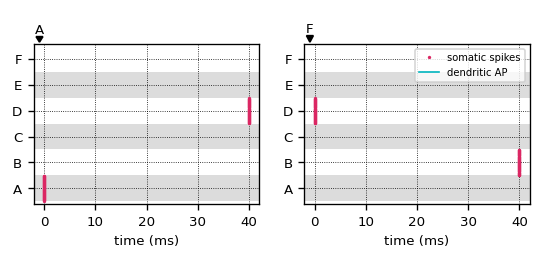

In [51]:
def plot_sequence_replay(PS):
        
    # get data of the first seed (1st network realization)
    PS_sel = copy.deepcopy(PS)
    PS_sel['DeltaT'] = 40.
    delta_idend = 1.
    
    params = shtm.helper.parameter_set_list(PS_sel)[0]
    num_neurons = params['M'] * params['n_E']
    
    # get training data
    sequences = load_data(".", 'training_data')
    vocabulary = load_data(".", 'vocabulary')
    
    print('#### sequences used for training ### ')
    for i, sequence in enumerate(sequences):
        seq = ''
        for char in sequence:
            seq += str(char).ljust(2)
        print('sequence %d: %s' % (i, seq))
    
    # get data path
    data_path = model_instance.data_path
    
    # load spikes
    somatic_spikes = shtm.helper.load_spike_data(data_path, 'somatic_spikes')
    idend = shtm.helper.load_spike_data(data_path, 'idend_last_episode')
    
    # get recoding and excitation times
    idend_recording_times = load_data(data_path, 'idend_recording_times')
    characters_to_subpopulations = load_data(data_path, 'characters_to_subpopulations')
    
    # get dendritic AP
    idx = np.where((idend[:, 2] > params['soma_params']['I_p']-delta_idend))[0]
    dendriticAP_currents = idend[:, 2][idx]
    dendriticAP_times = idend[:, 1][idx]
    dendriticAP_senders = idend[:, 0][idx]
    
    # get excitation times
    excitation_times = load_data(data_path, 'excitation_times')
    
    #################################
    # Plot routing 
    # -------------------------------
    
    # plot settings 
    plt.rcParams['font.size'] = 8
    plt.rcParams['legend.fontsize'] = 6
    plt.rcParams['figure.figsize'] = (7.,2.)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['text.usetex'] = False
    panel_label_pos = (-0.12,1.1)
    color_soma_spike = '#DB2763'
    color_dendrite_spike = '#00B4BE' 
    fc = '#dcdcdc'
    fraction_active = 3
    ms = 1.
    lw = 1.
    
    colormap = plt.cm.hsv
    step = 10
    num_plots = 10
    tt_steps = num_plots * step
    
    ymin = -0.1
    ymax = 5
    xmin = 0
    xmax = 40.
    shift_x = 1.
    shift_y = 15.
    
    ###################################
    # Visualize data 
    #----------------------------------
    
    # organize the characters for plotting purpose
    subpopulation_indices = []
    chars_per_subpopulation = [] 
    for char in vocabulary:
        # shift the subpopulation indices for plotting purposes 
        char_to_subpopulation_indices = characters_to_subpopulations[char]
        subpopulation_indices.extend(char_to_subpopulation_indices)
    
        #sub_subpopulations.extend(h['characters_to_subpopulations'][char])
        chars_per_subpopulation.extend(char * len(characters_to_subpopulations[char]))
    
    shifted_subpopulation_indices = np.array(subpopulation_indices) + 0.5
    
    ################################
    # show soma and dendritic spikes
    # ------------------------------ 
    fig = plt.figure()
    gs = mpl.gridspec.GridSpec(2, 5, height_ratios=[3,15], width_ratios=[15,3,15,4,15], bottom=0.2, top=1., left=0.05, right=0.98, wspace=0., hspace=0.)
    
    # select data for first sequence
    # ------------------------------
    start_time = 0 
    end_time = excitation_times[0] + params['DeltaT_cue']
    
    # select data to show for somatic spikes
    idx_somatic_spikes = np.where((somatic_spikes[:,1] > start_time) & (somatic_spikes[:,1] < end_time))
    
    somatic_spikes_times = somatic_spikes[:,1][idx_somatic_spikes]
    somatic_spikes_senders = somatic_spikes[:,0][idx_somatic_spikes]
    initial_time = somatic_spikes_times[0]
    somatic_spikes_times -= initial_time
    #xmax = times_somatic_spikes[-1] + shift_x
    
    # select data to show for dendritic spikes
    idx_dAP = np.where((dendriticAP_times > start_time) & (dendriticAP_times < end_time))
    dAP_senders = dendriticAP_senders[idx_dAP]
    dAP_currents = dendriticAP_currents[idx_dAP]
    dAP_times = dendriticAP_times[idx_dAP]
    dAP_times -= initial_time
    
    # select excitation times
    ind_times = np.where((excitation_times > start_time) & (excitation_times < end_time))  
    excitation_times_sel = excitation_times[ind_times]
    
    # draw stimulus
    # -------------
    plt.subplot(gs[0,0])
    plt.axis('off')
    
    width = 0.03
    height = 0.22
    e = 0.05   # for some reason the x coordinate of the bottom point needs to be shifted to not overlap with the x-axis  
    
    len_x_axis = xmax + shift_x
    
    x = (excitation_times[0]-initial_time+shift_x+2.) / len_x_axis
    y = height
    pos = [x,y]
    
    X = np.array([pos, [pos[0]+width,pos[1]], [pos[0]+width/2, e]])
    t1 = plt.Polygon(X, color='black')
    plt.gca().add_patch(t1)
    plt.text(pos[0]-0.005, pos[1]+0.1, 'A')
    
    # show first sequence
    # --------------
    ax=plt.subplot(gs[1,0])
    #utils.panel_label('A',panel_label_pos)
    
    # subsamples neurons to show
    senders_subsampled = somatic_spikes_senders[::fraction_active]
    line1 = plt.plot(somatic_spikes_times[::fraction_active], somatic_spikes_senders[::fraction_active], 'o', color=color_soma_spike, lw=0., ms=ms, zorder=2)
    
    for sender in senders_subsampled:
        ind_ds = np.where(dAP_senders == sender)
        line2 = plt.plot(dAP_times[ind_ds], dAP_senders[ind_ds], color=color_dendrite_spike, lw=lw, zorder=1)
    
    #plt.xlim(-shift_x, xmax)
    plt.ylim(-shift_y, num_neurons+shift_y)
    plt.xlabel('time (ms)')
    
    conn_matrix_ticks_pos = shifted_subpopulation_indices * params['n_E']
    conn_matrix_ticks_label = chars_per_subpopulation
    subpopulation_indices_background = np.arange(params['M'])*params['n_E']
    
    plt.yticks(conn_matrix_ticks_pos, conn_matrix_ticks_label)
    
    for i in range(params['M'])[::2]:
        plt.axhspan(subpopulation_indices_background[i], subpopulation_indices_background[i]+params['n_E'], facecolor=fc, zorder=0)
    
    #labels = ['somatic spikes', 'dendritic AP']
    #plt.legend((line1[0], line2[0]), labels, loc='lower right')
    
    # select data for second sequence
    # ------------------------------
    start_time = excitation_times[1] 
    end_time = excitation_times[1] + params['DeltaT_cue']
    
    # select data to show for somatic spikes
    idx_somatic_spikes = np.where((somatic_spikes[:,1] > start_time) & (somatic_spikes[:,1] < end_time))
    
    somatic_spikes_times = somatic_spikes[:,1][idx_somatic_spikes]
    somatic_spikes_senders = somatic_spikes[:,0][idx_somatic_spikes]
    initial_time = somatic_spikes_times[0]
    somatic_spikes_times -= initial_time
    #xmax = times_somatic_spikes[-1] + shift_x
    
    # select data to show for dendritic spikes
    idx_dAP = np.where((dendriticAP_times > start_time) & (dendriticAP_times < end_time))
    dAP_senders = dendriticAP_senders[idx_dAP]
    dAP_current = dendriticAP_currents[idx_dAP]
    dAP_times = dendriticAP_times[idx_dAP]
    dAP_times -= initial_time
    
    # select excitation times
    ind_times = np.where((excitation_times > start_time) & (excitation_times < end_time))  
    excitation_times_sel = excitation_times[ind_times]
    
    # draw stimulus
    # -------------
    plt.subplot(gs[:,1])
    plt.axis('off')
    plt.subplot(gs[0,2])
    plt.axis('off')
    
    width = 0.03
    height = 0.25
    e = 0.05   # for some reason the x coordinate of the bottom point needs to be shifted to not overlap with the x-axis  
    
    len_x_axis = xmax + shift_x
    x = (excitation_times[1]-initial_time+shift_x+2.) / len_x_axis
    y = height
    pos = [x,y]
     
    X = np.array([pos, [pos[0]+width,pos[1]], [pos[0]+width/2, e]])
    t1 = plt.Polygon(X, color='black')
    plt.gca().add_patch(t1)
    plt.text(pos[0]-0.003, pos[1]+0.1, 'F')
    
    # show second sequence
    # ---------------
    plt.subplot(gs[1,2])
    #utils.panel_label('B',panel_label_pos)
    
    # subsamples neurons to show
    senders_subsampled = somatic_spikes_senders[::fraction_active]
    line1 = plt.plot(somatic_spikes_times[::fraction_active], somatic_spikes_senders[::fraction_active], 'o', color=color_soma_spike, lw=0., ms=ms, zorder=2)
    
    for sender in senders_subsampled:
        ind_ds = np.where(dAP_senders == sender)
        line2 = plt.plot(dAP_times[ind_ds], dAP_senders[ind_ds], color=color_dendrite_spike, lw=lw, zorder=1)
    
    #plt.xlim(-shift_x, xmax)
    plt.ylim(-shift_y, num_neurons+shift_y)
    plt.xlabel('time (ms)')
    
    #TODO revise this, scale should be divided by fraction_active
    conn_matrix_ticks_pos = shifted_subpopulation_indices * params['n_E']
    conn_matrix_ticks_label = chars_per_subpopulation
    subpopulation_indices_background = np.arange(params['M'])* params['n_E']
    
    plt.yticks(conn_matrix_ticks_pos, conn_matrix_ticks_label)
    
    for i in range(params['M'])[::2]:
        plt.axhspan(subpopulation_indices_background[i], subpopulation_indices_background[i]+params['n_E'], facecolor=fc, zorder=0)
    
    labels = ['somatic spikes', 'dendritic AP']
    plt.legend((line1[0], line2[0]), labels, loc='upper right')
    
    # sequence recall duration
    #-------------------------
    """
    # gather data
    parameter_key_list = ['seed', 'DeltaT']
    data_key_list = ['mean_replay_duration', 'std_replay_duration']
    lw_sd = 2. 
    bar_color = '#e8e8e8'
    
    fname = 'replay_duration'
    data, params = utils.gather_data(parameter_key_list, data_key_list, path_dict, add_to_path='replay', fname=fname)
    
    plt.subplot(gs[1,4])
    panel_label_pos_C = (panel_label_pos[0]-0.07, panel_label_pos[1])
    utils.panel_label('C',panel_label_pos_C)
    
    mean_recall_duration = np.mean(data['mean_replay_duration'], 0)[:, 0]
    std_recall_duration = np.std(data['mean_replay_duration'], 0)[:, 0]
    excitation_steps = PS['DeltaT']._values
    
    plt.plot(excitation_steps, mean_recall_duration, lw=lw_sd, color='black')
    plt.fill_between(excitation_steps, mean_recall_duration+std_recall_duration, mean_recall_duration-std_recall_duration, facecolor=bar_color)
    
    # filling in the region in which the precition performance is not optimal
    xmin = 3
    xmax = 85  
    ymin = 0. #min(mean_recall_duration) - 2
    ymax = max(mean_recall_duration) + 12
    plt.fill_between([xmin,10], [ymin,ymin], [ymax,ymax], facecolor=fc)
    plt.fill_between([70,xmax], [ymin,ymin], [ymax,ymax], facecolor=fc)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel("interstimulus interval $\Delta T$ (ms)")
    plt.ylabel("replay duration (ms)")
    """    

    # save figure
    path = '.'
    fname = 'sequence_replay'
    print('---------------------------------------------')
    print('save figure to %s/%s.png ...' % (path, fname))
    plt.savefig('%s/%s.png' % (path, fname))

plot_sequence_replay(params)

#### sequences used for training ###
sequence 0: A D B E 
sequence 1: F D B C 
		 data set 1/1: 6a496b4be2d415cae8f3300e2dd2ed7e/prediction_performance
		 data set 1/1: 6a496b4be2d415cae8f3300e2dd2ed7e/prediction_performance
		 data set 1/1: 6a496b4be2d415cae8f3300e2dd2ed7e/prediction_performance
		 data set 1/1: 6a496b4be2d415cae8f3300e2dd2ed7e/prediction_performance
		 data set 1/1: 6a496b4be2d415cae8f3300e2dd2ed7e/prediction_performance
plot prediction performance ...


ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

> /home/charl/.local/lib/python3.11/site-packages/matplotlib/axes/_base.py(499)_plot_args()
    497 
    498         if x.shape[0] != y.shape[0]:
--> 499             raise ValueError(f"x and y must have same first dimension, but "
    500                              f"have shapes {x.shape} and {y.shape}")
    501         if x.ndim > 2 or y.ndim > 2:



ipdb>  q


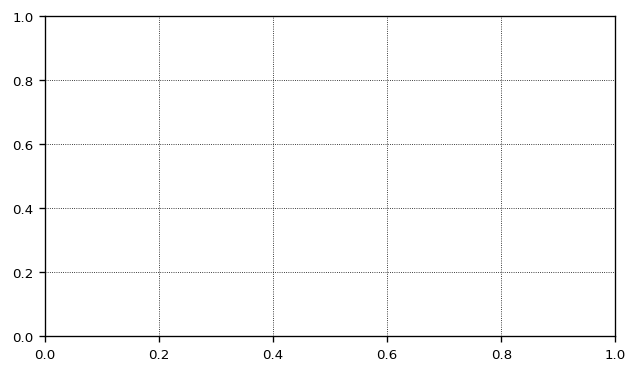

In [37]:
def mean_confidence_interval(y, use_percentile=True):
    """
    Computes the mean and standard deviation or median and percentile (5%, 95%) of the variable y
    

    Parameters
    ----------
    y                : ndarray
    use_percentile   : bool

    Returns
    -------
    mean_y       : ndarray
    mean_y_lower : ndarray
    mean_y_upper : ndarray
    """

    if use_percentile:
        mean_y = np.median(y, axis=0)
        mean_y_lower = np.percentile(y, 5, axis=0)
        mean_y_upper = np.percentile(y, 95, axis=0)
    else:
        mean_y = np.mean(y, axis=0)
        std_y = np.std(y, axis=0)
        mean_y_lower = mean_y - std_y
        mean_y_upper = mean_y + std_y

    return mean_y, mean_y_lower, mean_y_upper


def plot_stimulus_timing_analysis(x, data, s, saving_paths, figure_name):
    """ Plot prediction performance versus interstimulus intervals. The prediction performance includes error,
    false negative and false positive

    Parameters
    ----------
    x     : array
        contains x-axis values
    data  : dict
    s     : sparsity level
        float
        dictionary containing errors, false negatives, and false positives
    saving_paths : list of string
        list containing paths to where to store the figure
    figure_name  : string
    """

    color_shtm = 'black'
    std_color = '#e8e8e8'
    color_lrs = 'brown'
    std_color_lrs = '#eeb9b9ff' #'#964b004d'
    color_sparsity = 'grey'
    lw = 1.5
    lw_s = 1.5
    lw_fn = 2.5
    N = 1

    # plot prediction error    
    # -----------------------
    plt.figure(figsize=(5.2, 3), constrained_layout=True)

    y = mean_confidence_interval(data['error'])
    mean_y, mean_y_lower, mean_y_upper = y

    plt.plot(x, mean_y, lw=lw, color=color_shtm)
    plt.fill_between(x, mean_y_lower, mean_y_upper, facecolor=std_color)

    plt.ylabel("prediction error")
    plt.xlabel("interstimulus interval $\Delta T$ (ms)")

    plt.xlim((min(x), max(x)))
    plt.ylim(ymin=-0.1)

    # combine prediction error and false negative/positive
    # using subplots
    # -----------------------------------------------------
    plt.figure()
    gs = mpl.gridspec.GridSpec(1, 4, width_ratios=[15,0.01,15,15], left=0.08, right=0.98, bottom=0.2, top=0.93, wspace=0.5, hspace=0.01)

    ax = plt.subplot(gs[0, 0])

    panel_label_pos = (-0.25, 1.08)
    panel_label('A', panel_label_pos)

    y = mean_confidence_interval(data['error'])
    mean_y, mean_y_lower, mean_y_upper = y

    yts = mean_confidence_interval(data['time_to_solution'])
    mean_yts, mean_yts_lower, mean_yts_upper = yts

    plt.plot(x, mean_y, lw=lw, color=color_shtm)
    plt.fill_between(x, mean_y_lower, mean_y_upper, facecolor=std_color)

    plt.ylabel("prediction error")
    plt.xlabel("interstimulus interval $\Delta T$ (ms)")
    plt.ylim(ymin=-0.01)
    plt.yticks(np.arange(0, max(mean_y) + 0.2, 0.2))
    plt.xticks(np.arange(15.,max(x),15.))

    # plot time to solution in the second axis
    ax2 = ax.twinx()
    
    plt.plot(x, mean_yts, lw=lw, color=color_lrs)
    plt.fill_between(x, mean_yts_lower, mean_yts_upper, facecolor=std_color_lrs)

    plt.ylabel("episodes-to-solution", color="brown")
    plt.ylim(ymin=-0.01)

    ax2.tick_params(axis='y', labelcolor='brown')
    plt.xlim((min(x), max(x)))

    # plot false positive and negative
    # --------------------------------
    plt.subplot(gs[0, 2])
    panel_label('B', panel_label_pos)

    y_fp = mean_confidence_interval(data['false_positive'])
    mean_y_fp, mean_y_fp_lower, mean_y_fp_upper = y_fp

    y_fn = mean_confidence_interval(data['false_negative'])
    mean_y_fn, mean_y_fn_lower, mean_y_fn_upper = y_fn

    plt.plot(x, mean_y_fn, lw=lw_fn, color=color_shtm, linestyle='dashed', label='false negative')
    plt.plot(x, mean_y_fp, lw=lw, color=color_shtm, linestyle='solid', label='false positive')
    plt.fill_between(x, mean_y_fn_lower, mean_y_fn_upper, facecolor=std_color)
    plt.fill_between(x, mean_y_fp_lower, mean_y_fp_upper, facecolor=std_color)

    plt.xlim((min(x), max(x)))
    plt.xlabel("interstimulus interval $\Delta T$ (ms)")
    plt.ylabel("rel. frequency")
    plt.ylim(ymin=-0.01)
    plt.xticks(np.arange(15.,max(x),15.))

    ax = plt.gca()
    leg = ax.legend(loc='upper center')

    for line in leg.get_lines():
        line.set_linewidth(lw)
    """
    # plot relative number of activate neurons
    # ----------------------------------------
    plt.subplot(gs[0, 3])
    panel_label('C', panel_label_pos)

    y = mean_confidence_interval(data['rel_active_neurons'])
    x, y = running_mean(x, y, N)
    mean_y, mean_y_lower, mean_y_upper = y

    mean_y[0] = mean_y[1]

    p1 = plt.plot(x, mean_y, lw=lw, color=color_shtm, linestyle='solid')
    plt.fill_between(x, mean_y_lower, mean_y_upper, facecolor=std_color)
    
    # add target sparsity level
    plt.hlines(s, x[0], x[-1], color=color_sparsity, ls='dotted', lw=lw_s)
    
    plt.xlim((min(x), max(x)))
    plt.xlabel("interstimulus interval $\Delta T$ (ms)")
    plt.ylabel("rel. no. of active neurons")
    plt.ylim(ymin=-0.01)
    plt.xticks(np.arange(15.,max(x),15.))
    """
    print('------------------------------------------------------------------')
    for saving_path in saving_paths:
        os.system('mkdir -p %s' % (saving_path))
        print("saving figure to " + saving_path + "/" + figure_name + '.png')
        plt.savefig(saving_path + "/" + figure_name + '.png')




def plot_replay(PS):
    PS_trials = copy.deepcopy(PS)
    PL = shtm.helper.parameter_set_list(PS_trials)
    
    # get training data
    sequences = load_data(".", "training_data")
    
    print("#### sequences used for training ###")
    for i, sequence in enumerate(sequences): 
        seq = '' 
        for char in sequence:
            seq += str(char).ljust(2) 
        print("sequence %d: %s" % (i, seq))
    
    # load data
    # ---------
    data_diff_run = defaultdict(list)
    fname = "prediction_performance"
    time_to_solutions = []
    for seed in PS['seed']:
    
        errors = []
        false_positives = []
        false_negatives = []
        rel_active_neurons = []
        time_to_solutions = []
        PS_trials['seed'] = seed
        PL = shtm.helper.parameter_set_list(PS_trials)
    
        for cP, params in enumerate(PL):
    
            # get data path
            data_path = model_instance.data_path
            print("\t\t data set %d/%d: %s/%s" % (cP + 1, len(PL), data_path, fname))
    
            # load prediction performance
            data = load_data(data_path, fname)
            try:
                idx_ts = np.where(data['error'] < 0.001)[0][0]
                time_to_solution = idx_ts * params['episodes_to_testing']
            except:
                time_to_solution = params['learning_episodes']
                idx_ts = -1
    
            errors.append(data['error'][-1])
            false_positives.append(data['false_positive'][-1])
            false_negatives.append(data['false_negative'][-1])
            rel_active_neurons.append(data['rel_active_neurons'][-1])
            #print(seed, data['error'][-1], data['false_positive'][-1], 
            #            data['false_negative'][-1], data['rel_active_neurons'][-1])
    
            time_to_solutions.append(time_to_solution)
    
        data_diff_run['error'].append(errors)
        data_diff_run['false_positive'].append(false_positives)
        data_diff_run['false_negative'].append(false_negatives)
        data_diff_run['rel_active_neurons'].append(rel_active_neurons)
        data_diff_run['time_to_solution'].append(time_to_solutions)
    
    # get x scans
    #data_diff_run['x'] = PS['DeltaT']._values
    s = (params['pattern_size'] - 1) / params['n_E']   # sparsity level
    
    # plot settings 
    plt.rcParams['font.size'] = 8
    plt.rcParams['legend.fontsize'] = 6
    plt.rcParams['figure.figsize'] = (7.,2.)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['text.usetex'] = False
    panel_label_pos = (-0.1,1.0)
    
    print("plot prediction performance ...")
    path = '.'
    fname = 'stimulus_timing_analysis'
    plot_stimulus_timing_analysis(data_diff_run['x'], data_diff_run, s, saving_paths=[path], figure_name=fname)

plot_replay(params)

References
----------

[1] Bouhadjar Y, Wouters DJ, Diesmann M, Tetzlaff T (2022) Sequence learning, prediction, and replay in networks of spiking neurons. PLoS Comput Biol 18(6): e1010233. https://doi.org/10.1371/journal.pcbi.1010233

